# Direct reconstruction from proton-proton momentum

In this notebook we will be using a data set for WW boson pair decays to recover the unknown kinematics of the semi-leptonic decay events. We consider the case in which we know the information of both protons after the collision, so the kinematics can be recovered by a simple momentum-conservation. We will also consider the effects of introducing a random errors (smearing) to the momentum components of the protons and the jets on the recovered kinematics.

Note that throughout this notebook we make a few key assumptions. The data we have is for a fully leptonic decay of the WW boson pair, in which both W bosons decay into a muon and an anti-neutrino. However, we assume that we have a semi-leptonic case by considering one of the muon anti-neutrino pair to be 2 jets. We also assume that we have the full kinematics for both protons, the muon, and the jets, but we don't know the kinematics of the neutrino and the WW boson pair.



## Importing needed modules and data

### Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.special import factorial
import scipy.optimize as opt
from scipy.optimize import fsolve

### Data

We note that the protons have energy of 6500GeV before they collide and they only move along the z-direction opposite to each other. What we have is the measurements after the collision.



In [2]:
ro_skip = []
for i in range(0,1000):
    skip0 = 0 + i*12
    skip1 = 1 + i*12
    skip2 = 2 + i*12
    ro_skip.append(skip0)
    ro_skip.append(skip1)
    ro_skip.append(skip2)


data = pd.read_table('evrecWWmu.dat',skiprows=ro_skip,delim_whitespace=True, names=['M.C.N', 'Unknown1', 'Unknown2', 'Unknown3','Unknown4','Unknown5','Px','Py','Pz','E','M','Unknown6','Unknown7'])

## Cutting the unnecessary values ##
data = data.loc[:, ~data.columns.isin(['Unknown1', 'Unknown2', 'Unknown3', 'Unknown4', 'Unknown5', 'Unknown6', 'Unknown7'])]
data

,M.C.N,Px,Py,Pz,E,M
0,2212,-0.121187,-0.107579,6441.689670,6441.689740,9.382720e-01
1,2212,0.002975,0.016852,-6040.814950,6040.815020,9.382720e-01
2,93,0.118212,0.090726,-400.874725,517.495236,3.272625e+02
3,24,-16.241844,-60.069347,-403.188810,415.793605,8.031800e+01
4,-24,16.360056,60.160073,2.314085,101.701632,8.031800e+01
...,...,...,...,...,...,...
8995,-24,-47.147039,-84.337639,64.643653,141.299199,8.031800e+01
8996,-14,27.185437,94.311133,383.002563,395.379060,4.672031e-06
8997,13,19.663434,-9.560594,36.150860,42.248686,1.056600e-01
8998,14,-10.673811,1.939353,44.084532,45.399750,5.331202e-07


In [3]:
## Locating an event ##
event_name = {}
for x in range(1,1001):
    event_name["event{0}".format(x)] = ()

In [4]:
start_point = 0
end_point = 9

for name in event_name:
            
        globals()[name] = data.iloc[start_point:end_point].reset_index(drop=True)
        
        start_point = start_point + 9        
        end_point = start_point +9

In [5]:
## event(n) gives the nth event, 65th event is: ##

event65

,M.C.N,Px,Py,Pz,E,M
0,2212,-0.491426,-1.183024,4308.709000,4308.709290,9.382720e-01
1,2212,0.002820,0.000344,-6494.517400,6494.517470,9.382720e-01
2,93,0.488606,1.182680,2185.808400,2196.773240,2.192092e+02
3,24,-35.079644,17.663384,457.426468,466.082108,8.031800e+01
4,-24,35.568250,-16.480705,1728.381930,1730.691130,8.031800e+01
5,-14,17.494827,-11.622589,49.962185,54.197541,5.331202e-07
6,13,-52.574470,29.285973,407.464283,411.884567,1.056600e-01
7,14,-6.194364,25.655073,786.497137,786.939832,1.182848e-05
8,-13,41.762614,-42.135778,941.884794,943.751300,1.056600e-01


#### Explaination of the data

The units of the table are natural units. The first column has the Monte-Carlo numbering scheme number for the particle.The monte-carlo numbering scheme is such that $2212$ is a proton, $\pm24$ is a $W^{\pm}$ boson respectively, $\pm 14$ are muon neutrino and anti-muon neutrino respectively, and $\pm13$ are muon adn anti-muon respectively. We consider the -14 and 13 as the (muon) anti-neutrino and the muon respectively **but 14 and -13 particles are jets**.


## 1)  Reconstruction with no detector smearing

In this section we use simple momentum conservation to obtain the momentum components of the anti-neutrino and the two W bosons. Note that we refer to the W boson that decays into an anti-neutrino and a muon as the first W boson (W1) and the other one as the second W boson (W2)

### The math used
We know that the initial total momentum is zero before collision (z-momentum components add up to zero). Hence, after the collision the sum of the momenta of all of the protons and the W bosons is equal to 0. In other words, the sum of the momenta of the protons is equal to the negative of the sum of momenta of the WW system. Now focusing on the WW system as a whole, we know that it decays into 2 jets, a muon and a neutrino. So by momentum-conservation, the momentum of the neutrino is equal to the momentum of the two W bosons minus the momenta of the muon and two jets. 



### Reconstruction for z component
We are doing the calculation for the z component only, but the same code can be used to find the x and y components by replacing all the $P_z$ with $P_x$ or $P_y$ respectivly. **NOTE** that we are filling empty arrays with the reconstructed neutrinos and W bosons to later plot for comparison.

Note we also make plots to compare the reconstructed $P_z$ with the corresponding measurments from the data set.

In [6]:
## assuming -14 is neutrino and 13 is muon and 14/-13 are JETS ##

pzrecon = np.empty((0,3), int) #reconstructed
pzmsure = np.empty((0,3), int) #measured
W1pzrecon = np.empty((0,3), int) #w1 reconstructed
W2pzrecon = np.empty((0,3), int) #w2 reconstructed
W1pzmsure = np.empty((0,3), int) #w1 measured
W2pzmsure = np.empty((0,3), int) #w2 measured

for y in range(1,1001):
    
    WWsystem = -1*(globals()[f'event{y}'].Pz[0]+globals()[f'event{y}'].Pz[1])  # WW system Pz = - total Pz of both protons
    ## now we minus the Pz value we know from the total WW system i.e. the muon and jets 
    neutrinoPz = WWsystem - globals()[f'event{y}'].Pz[6] - globals()[f'event{y}'].Pz[7] - globals()[f'event{y}'].Pz[8]
    w1 = neutrinoPz + globals()[f'event{y}'].Pz[6]
    w2 = globals()[f'event{y}'].Pz[7] + globals()[f'event{y}'].Pz[8]
    #print("v_mu Pz=",neutrinoPz,"W1 Pz=",w1,"W2 Pz=",w2,"for event",y)
    
    pzrecon = np.append(pzrecon,neutrinoPz) # filling array with the reconstructed Pz for neutrino
    pzmsure = np.append(pzmsure,globals()[f'event{y}'].Pz[5]) # filling array with the measured Pz for neutrino
    W1pzrecon = np.append(W1pzrecon,w1)
    W2pzrecon = np.append(W2pzrecon,w2)
    W1pzmsure = np.append(W1pzmsure,globals()[f'event{y}'].Pz[3])
    W2pzmsure = np.append(W2pzmsure,globals()[f'event{y}'].Pz[4])

#### Plotting reconstructed againt measured values

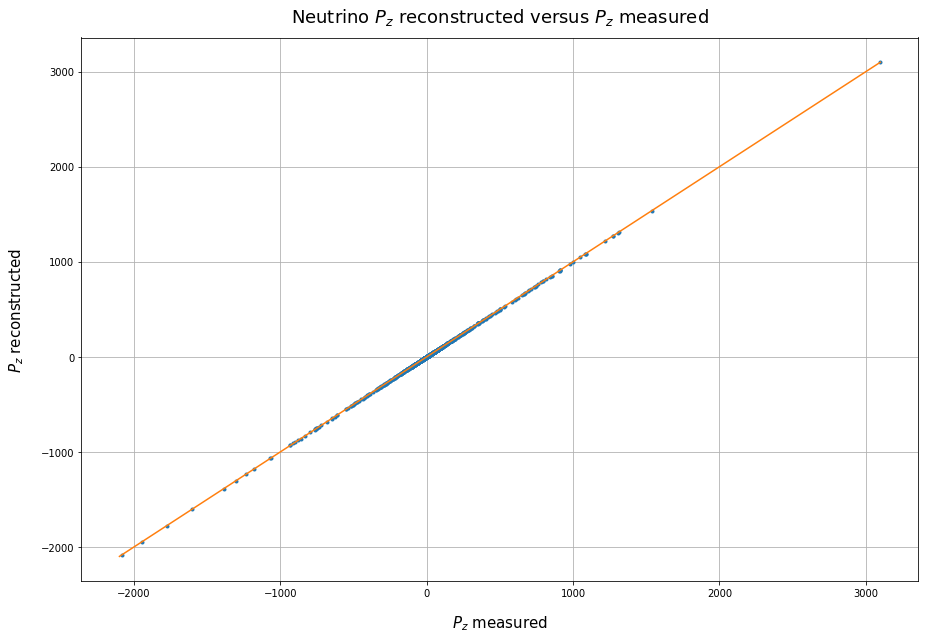

In [7]:
## Measured against reconstructed for neutrino##
plt.figure(figsize=[15,10])
plt.plot(pzmsure,pzrecon,".")
plt.plot(np.linspace(-2100,3100,1000),np.linspace(-2100,3100,1000))
plt.grid(True)
plt.xlabel("$P_z$ measured",labelpad = 15, size= 15)
plt.ylabel("$P_z$ reconstructed",labelpad = 15, size= 15)
plt.title("Neutrino $P_z$ reconstructed versus $P_z$ measured",pad = 15, size= 18);

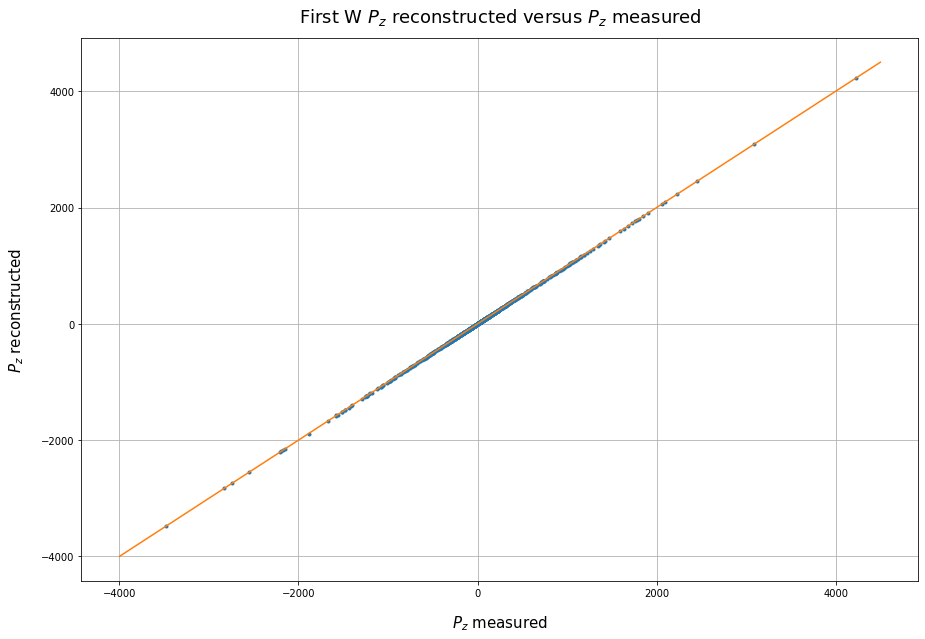

In [8]:
## Measured against reconstructed for first W ##
plt.figure(figsize=[15,10])
plt.plot(W1pzmsure,W1pzrecon,".")
plt.plot(np.linspace(-4000,4500,4500),np.linspace(-4000,4500,4500))
plt.grid(True)
plt.xlabel("$P_z$ measured",labelpad = 15, size= 15)
plt.ylabel("$P_z$ reconstructed",labelpad = 15, size= 15)
plt.title("First W $P_z$ reconstructed versus $P_z$ measured",pad = 15, size= 18);

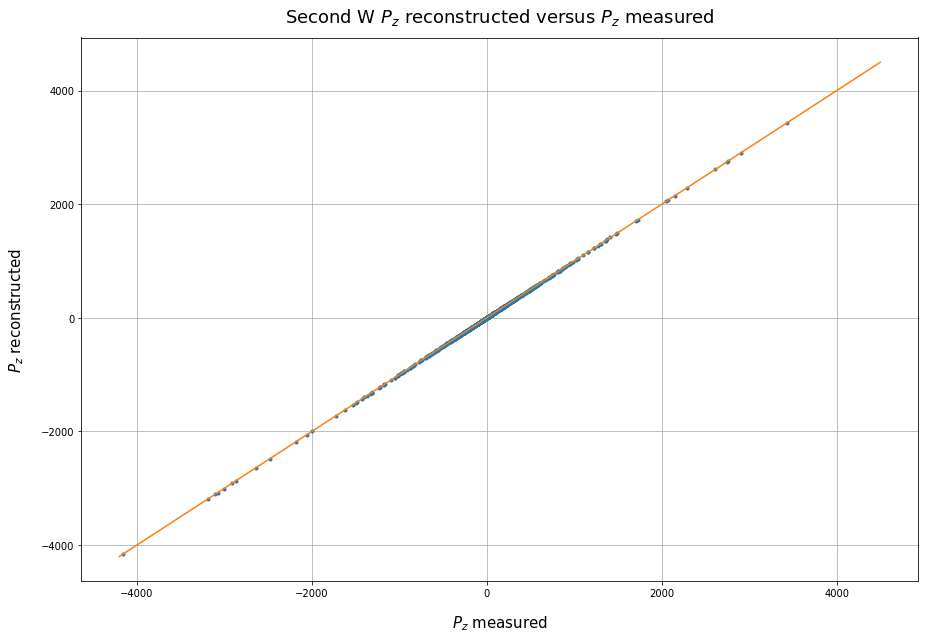

In [9]:
## Measured against reconstructed for second W ##
plt.figure(figsize=[15,10])
plt.plot(W2pzmsure,W2pzrecon,".")
plt.plot(np.linspace(-4200,4500,4500),np.linspace(-4200,4500,4500))
plt.grid(True)
plt.xlabel("$P_z$ measured",labelpad = 15, size= 15)
plt.ylabel("$P_z$ reconstructed",labelpad = 15, size= 15)
plt.title("Second W $P_z$ reconstructed versus $P_z$ measured",pad = 15, size= 18);

We see that as expected these plots are almost perfectly an x=y plot.

#### Plotting the differences between reconstructed and measured momenta

What we will do here is plot the distribution of difference between the measured and reconstructed momenta for each of the neutrino and the W bosons as a histogram. We will also make a plot to compare the difference of differences for the neutrino and the first W boson (the one that decays to form the neutrino and the muon).

For each distribution we also calculte the root mean square (rms).

The rms of the distribution is  4.155611806942412e-06


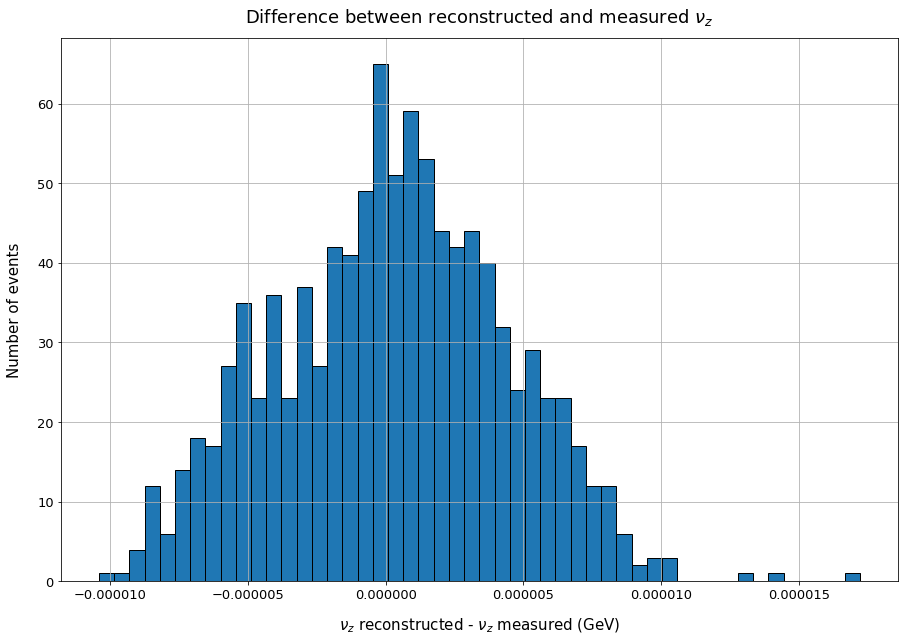

In [10]:
## Difference between measured & reconstructed for neutrino ##
diffpz = pzrecon-pzmsure
plt.figure(figsize=[15,10])
plt.hist(diffpz,bins = 50, ec='black')
plt.grid(True)
plt.xlabel(r"$\nu_z$ reconstructed - $\nu_z$ measured (GeV)",labelpad = 15, size= 15)
plt.xticks(fontsize= 13 )
plt.yticks(fontsize=13)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title(r"Difference between reconstructed and measured $\nu_z$",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffpz**2)) # rms of the distribution
print("The rms of the distribution is ", rms)
plt.savefig("Hist of recons 2p.png")

The rms of the distribution is  4.1994528466220276e-06


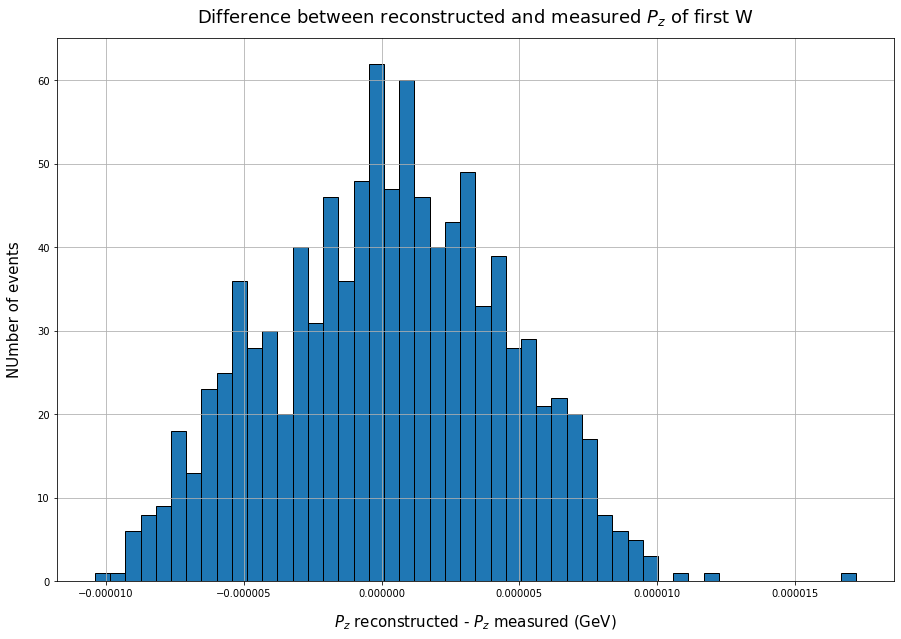

In [11]:
## Difference between measured & reconstructed for first W ##
diffw1z = W1pzrecon-W1pzmsure
plt.figure(figsize=[15,10])
plt.hist(diffw1z,bins = 50, ec="black")
plt.grid(True)
plt.xlabel("$P_z$ reconstructed - $P_z$ measured (GeV)",labelpad = 15, size= 15)
plt.ylabel("NUmber of events",labelpad = 15, size= 15)
plt.title("Difference between reconstructed and measured $P_z$ of first W",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffw1z**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

The rms of the distribution is  1.0142503062317759e-06


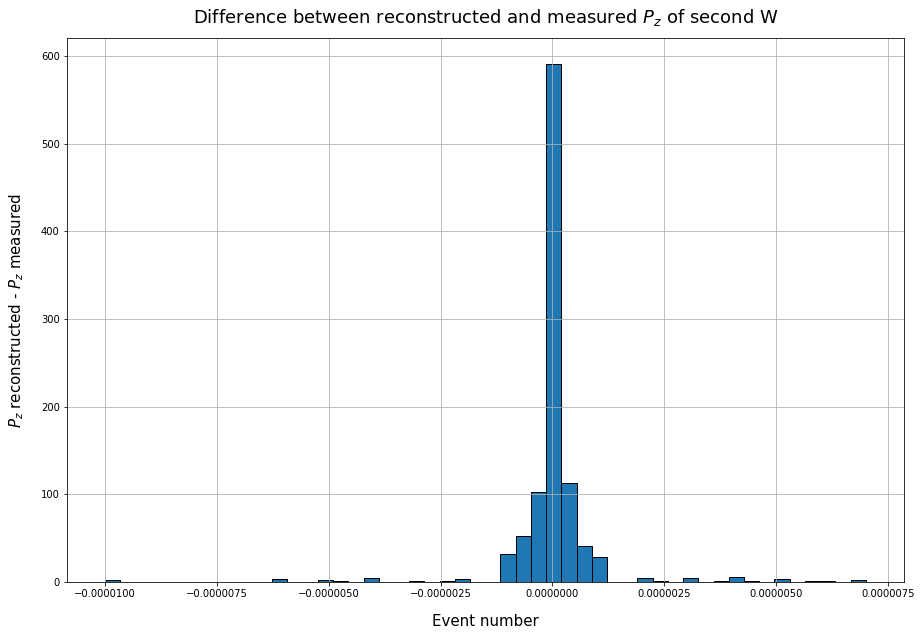

In [12]:
## Difference between measured & reconstructed for second W ##
diffw2z = W2pzrecon-W2pzmsure
plt.figure(figsize=[15,10])
plt.hist(diffw2z,bins=50, ec='black')
plt.grid(True)
plt.ylabel("$P_z$ reconstructed - $P_z$ measured",labelpad = 15, size= 15)
plt.xlabel("Event number",labelpad = 15, size= 15)
plt.title("Difference between reconstructed and measured $P_z$ of second W",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffw2z**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

The rms of the distribution is  1.0932310921352336e-06


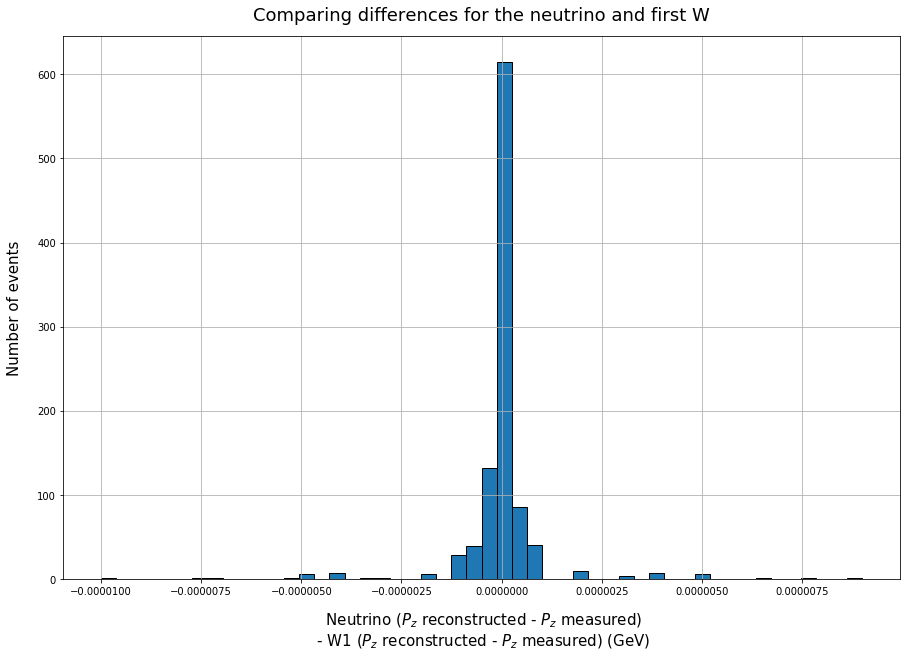

In [13]:
## Comparing diffences for the neutrino and w1##
compare_n_w1 = diffw1z-diffpz
plt.figure(figsize=[15,10])
plt.hist(compare_n_w1,bins=50,ec='black')
plt.grid(True)
plt.xlabel(" Neutrino ($P_z$ reconstructed - $P_z$ measured)\n - W1 ($P_z$ reconstructed - $P_z$ measured) (GeV)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Comparing differences for the neutrino and first W",pad = 15, size= 18);
rms = np.sqrt(np.mean(compare_n_w1**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

#### Interpreting these results

We first note that for W2 the reconstructed were the sum of the $P_z$ of the two jets. So the error we obtained is from the rounding errors when importing the data and from the uncertainity of the measurements in the data set. In other words, the sum of the $P_z$ of the two jets isn't exactly equal to the $P_z$ of W2 in the data set with an error in the 6th decimal place. 
Now for Neutrino the difference between the reconstructed and measured data was still in the 6th decimal place for most events. Only 7 events had a difference in the 5th decimal place. Again this is likely due to a rounding error in importing the data set which resulted in a slightly more difference.

For W1 the error was from the error in the neutrino plus the error in adding the neutrino and muon, with the latter being similar to the error for W2 as seen in the last plot (previous cell). Again this extra error of W1 compared to the neutrino is due to rounding errors when importing the data and the uncertainity of the measurements in the data set.


### Doing the code for the x & y momentum components

We follow the same code for calculating the z components.

#### For Px

In [14]:
## assuming -14 is neutrino and 13 is muon and 14/-13 are JETS ##

pxrecon = np.empty((0,3), int) #reconstructed
pxmsure = np.empty((0,3), int) #measured
W1pxrecon = np.empty((0,3), int) #w1 reconstructed
W2pxrecon = np.empty((0,3), int) #w2 reconstructed
W1pxmsure = np.empty((0,3), int) #w1 measured
W2pxmsure = np.empty((0,3), int) #w2 measured

for y in range(1,1001):
    
    WWsystem = -1*(globals()[f'event{y}'].Px[0]+globals()[f'event{y}'].Px[1])  # WW system Px = - total Px of both protons
    ## now we minus the Px value we know from the total WW system i.e. the muon and jets 
    neutrinoPx = WWsystem - globals()[f'event{y}'].Px[6] - globals()[f'event{y}'].Px[7] - globals()[f'event{y}'].Px[8]
    w1 = neutrinoPx + globals()[f'event{y}'].Px[6]
    w2 = globals()[f'event{y}'].Px[7] + globals()[f'event{y}'].Px[8]
    #print("v_mu Px=",neutrinoPx,"W1 Px=",w1,"W2 Px=",w2,"for event",y)
    
    pxrecon = np.append(pxrecon,neutrinoPx) # filling array with the reconstructed Px for neutrino
    pxmsure = np.append(pxmsure,globals()[f'event{y}'].Px[5]) # filling array with the measured Px for neutrino
    W1pxrecon = np.append(W1pxrecon,w1)
    W2pxrecon = np.append(W2pxrecon,w2)
    W1pxmsure = np.append(W1pxmsure,globals()[f'event{y}'].Px[3])
    W2pxmsure = np.append(W2pxmsure,globals()[f'event{y}'].Px[4])

The rms of the distribution is  1.0953947720769663e-07


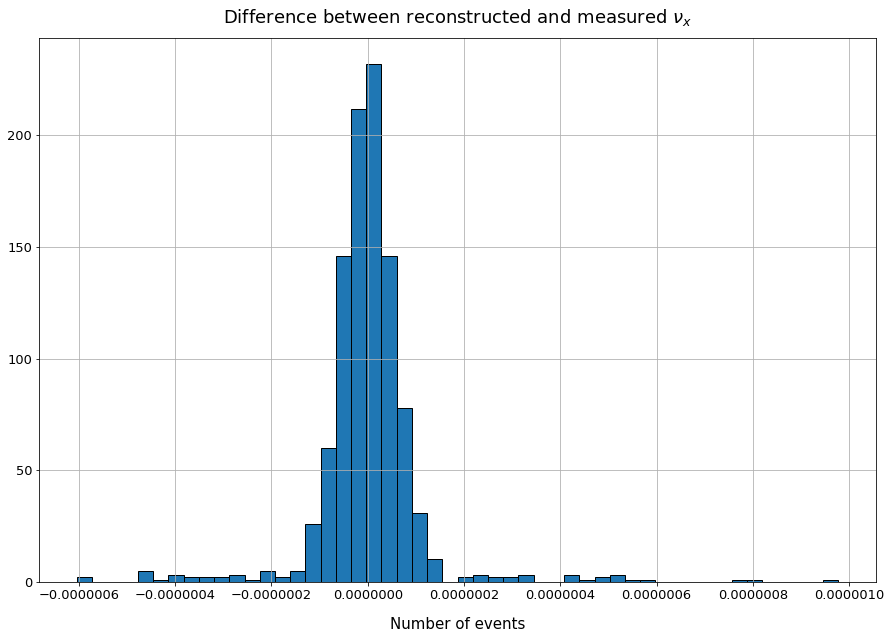

In [15]:
## Difference between measured & reconstructed for neutrino ##
diffpx = pxrecon-pxmsure
plt.figure(figsize=[15,10])
plt.hist(diffpx,bins=50,ec="black")
plt.grid(True)
plt.xlabel(r"$\nu_x$ reconstructed - $\nu_x$ measured (Gev)",labelpad = 15, size= 15)
plt.xlabel("Number of events",labelpad = 15, size= 15)
plt.xticks(fontsize= 13 )
plt.yticks(fontsize=13)
plt.title(r"Difference between reconstructed and measured $\nu_x$",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffpx**2)) # rms of the distribution
print("The rms of the distribution is ", rms)
plt.savefig("Hist 2 for 2p case.png" )

The rms of the distribution is  1.2084923049179073e-07


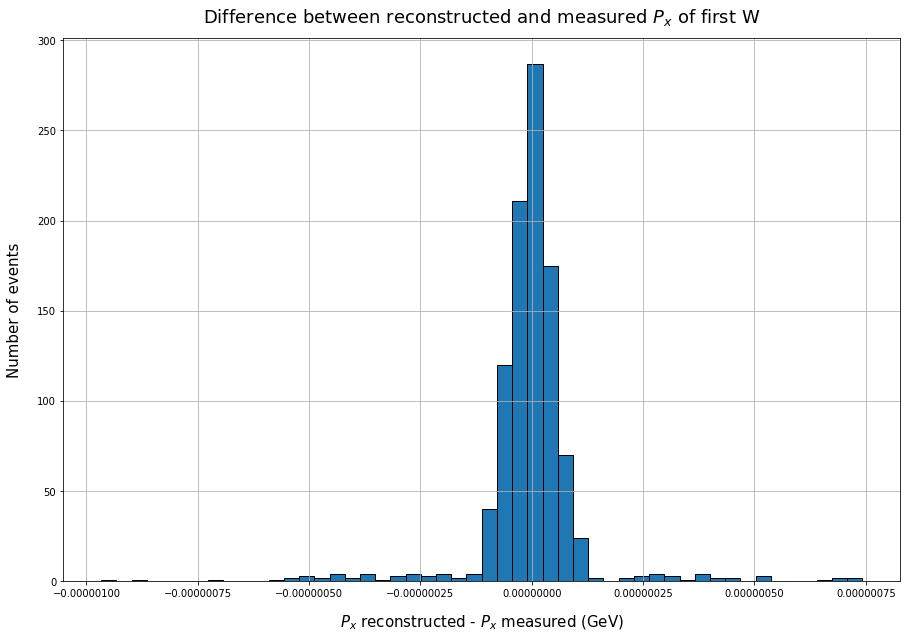

In [16]:
## Difference between measured & reconstructed for first W ##
diffw1x = W1pxrecon-W1pxmsure
plt.figure(figsize=[15,10])
plt.hist(diffw1x,bins=50, ec='black')
plt.grid(True)
plt.xlabel("$P_x$ reconstructed - $P_x$ measured (GeV)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Difference between reconstructed and measured $P_x$ of first W",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffw1x**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

The rms of the distribution is  1.209723800434899e-07


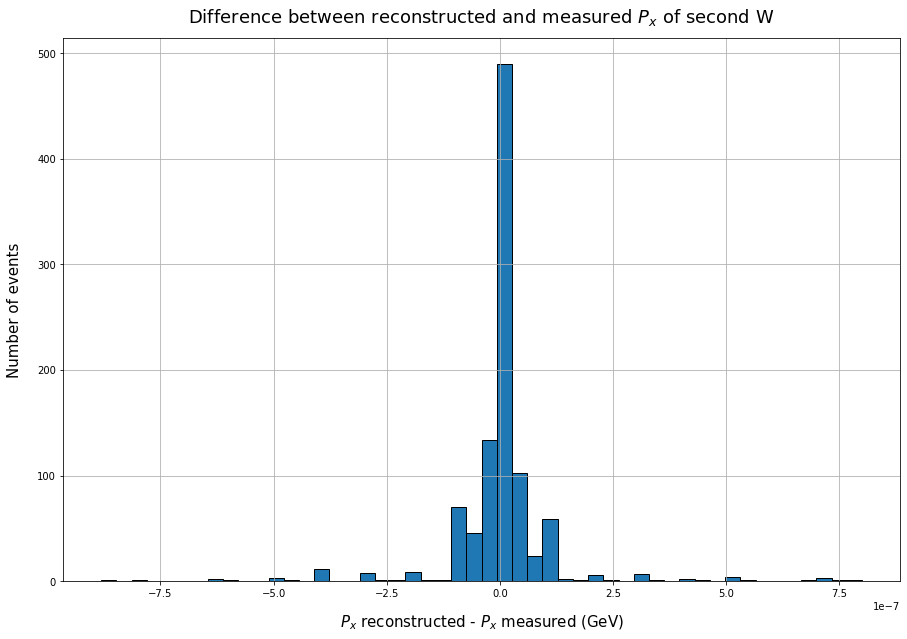

In [17]:
## Difference between measured & reconstructed for second W ##
diffw2x = W2pxrecon-W2pxmsure
plt.figure(figsize=[15,10])
plt.hist(diffw2x,bins=50, ec='black')
plt.grid(True)
plt.xlabel("$P_x$ reconstructed - $P_x$ measured (GeV)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Difference between reconstructed and measured $P_x$ of second W",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffw2x**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

The rms of the distribution is  1.275110303293441e-07


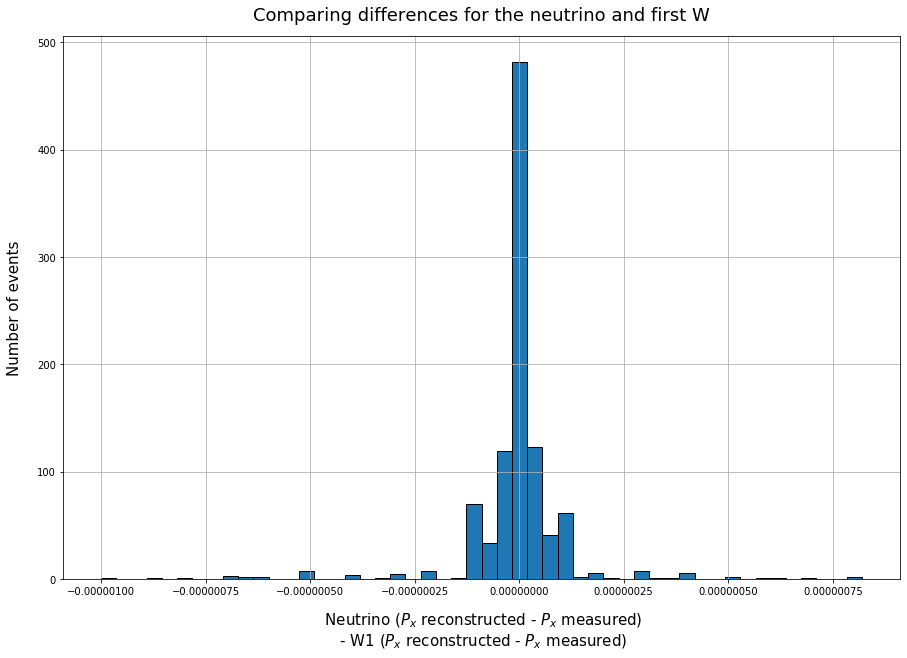

In [18]:
## Comparing diffences for the neutrino and w1##
compare_n_w1 = diffw1x-diffpx
plt.figure(figsize=[15,10])
plt.hist(compare_n_w1,bins=50, ec='black')
plt.grid(True)
plt.xlabel(" Neutrino ($P_x$ reconstructed - $P_x$ measured)\n - W1 ($P_x$ reconstructed - $P_x$ measured)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Comparing differences for the neutrino and first W",pad = 15, size= 18);
rms = np.sqrt(np.mean(compare_n_w1**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

#### Interpreting these results
We note that we have a trend similar to the Pz component but the errors are in the 6th and 7th decimal places.

#### For Py

In [19]:
## assuming -14 is neutrino and 13 is muon and 14/-13 are JETS ##

pyrecon = np.empty((0,3), int) #reconstructed
pymsure = np.empty((0,3), int) #measured
W1pyrecon = np.empty((0,3), int) #w1 reconstructed
W2pyrecon = np.empty((0,3), int) #w2 reconstructed
W1pymsure = np.empty((0,3), int) #w1 measured
W2pymsure = np.empty((0,3), int) #w2 measured

for y in range(1,1001):
    
    WWsystem = -1*(globals()[f'event{y}'].Py[0]+globals()[f'event{y}'].Py[1])  # WW system Py = - total Py of both protons
    ## now we minus the Py value we know from the total WW system i.e. the muon and jets 
    neutrinoPy = WWsystem - globals()[f'event{y}'].Py[6] - globals()[f'event{y}'].Py[7] - globals()[f'event{y}'].Py[8]
    w1 = neutrinoPy + globals()[f'event{y}'].Py[6]
    w2 = globals()[f'event{y}'].Py[7] + globals()[f'event{y}'].Py[8]
    #print("v_mu Py=",neutrinoPy,"W1 Py=",w1,"W2 Py",w2,"for event",y)
    
    pyrecon = np.append(pyrecon,neutrinoPy) # filling array with the reconstructed Py for neutrino
    pymsure = np.append(pymsure,globals()[f'event{y}'].Py[5]) # filling array with the measured Px for neutrino
    W1pyrecon = np.append(W1pyrecon,w1)
    W2pyrecon = np.append(W2pyrecon,w2)
    W1pymsure = np.append(W1pymsure,globals()[f'event{y}'].Py[3])
    W2pymsure = np.append(W2pymsure,globals()[f'event{y}'].Py[4])

The rms of the distribution is  1.0367731176067656e-07


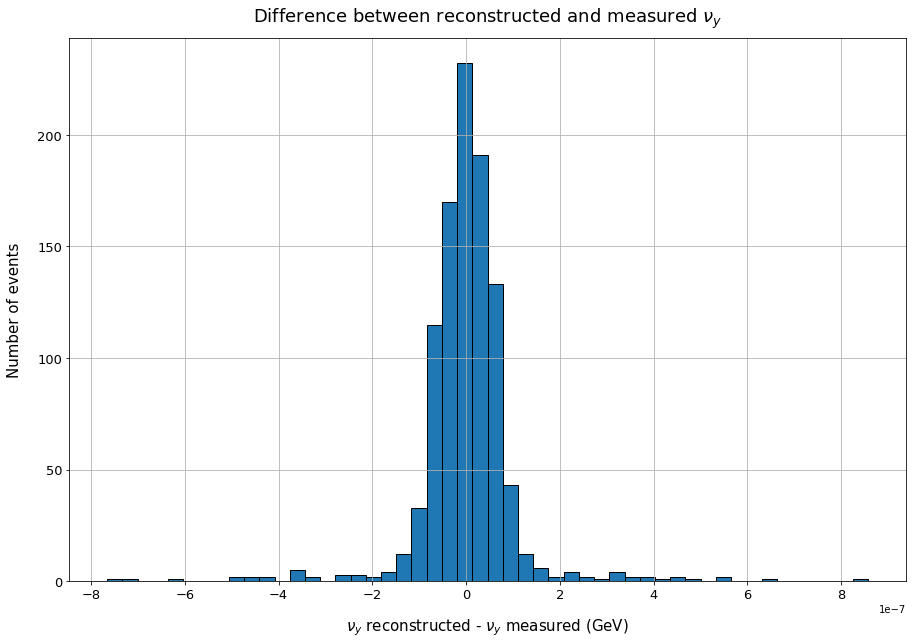

In [20]:
## Difference between measured & reconstructed for neutrino ##
diffpy = pyrecon-pymsure
plt.figure(figsize=[15,10])
plt.hist(diffpy,bins=50,ec='black')
plt.grid(True)
plt.xlabel(r"$\nu_y$ reconstructed - $\nu_y$ measured (GeV)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.xticks(fontsize= 13 )
plt.yticks(fontsize=13)
plt.title(r"Difference between reconstructed and measured $\nu_y$",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffpy**2)) # rms of the distribution
print("The rms of the distribution is ", rms)
plt.savefig("v_y hist of 2p case.png")

The rms of the distribution is  1.2130886398373403e-07


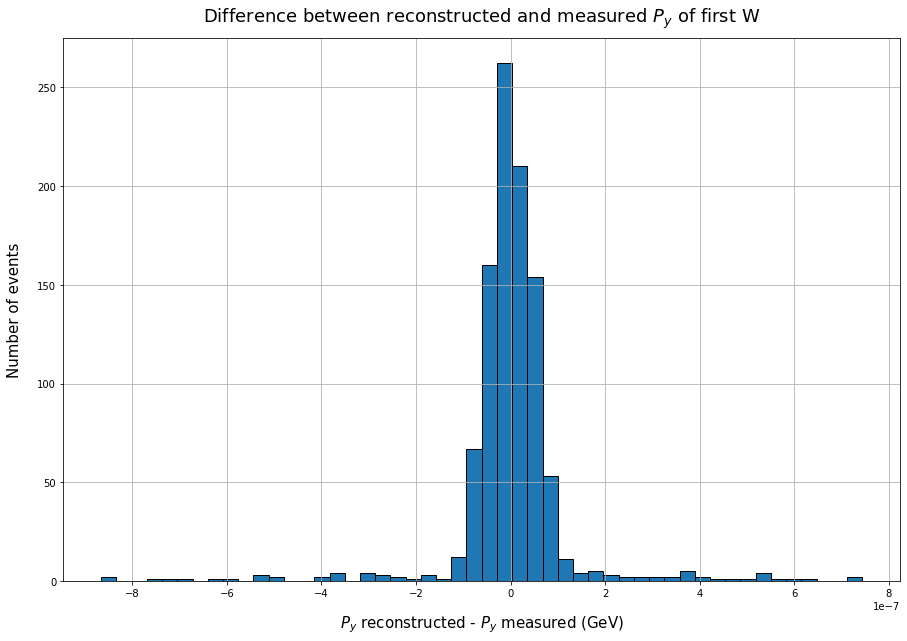

In [21]:
## Difference between measured & reconstructed for first W ##
diffw1y = W1pyrecon-W1pymsure
plt.figure(figsize=[15,10])
plt.hist(diffw1y,bins=50,ec='black')
plt.grid(True)
plt.xlabel("$P_y$ reconstructed - $P_y$ measured (GeV)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Difference between reconstructed and measured $P_y$ of first W",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffw1y**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

The rms of the distribution is  1.1921412107425746e-07


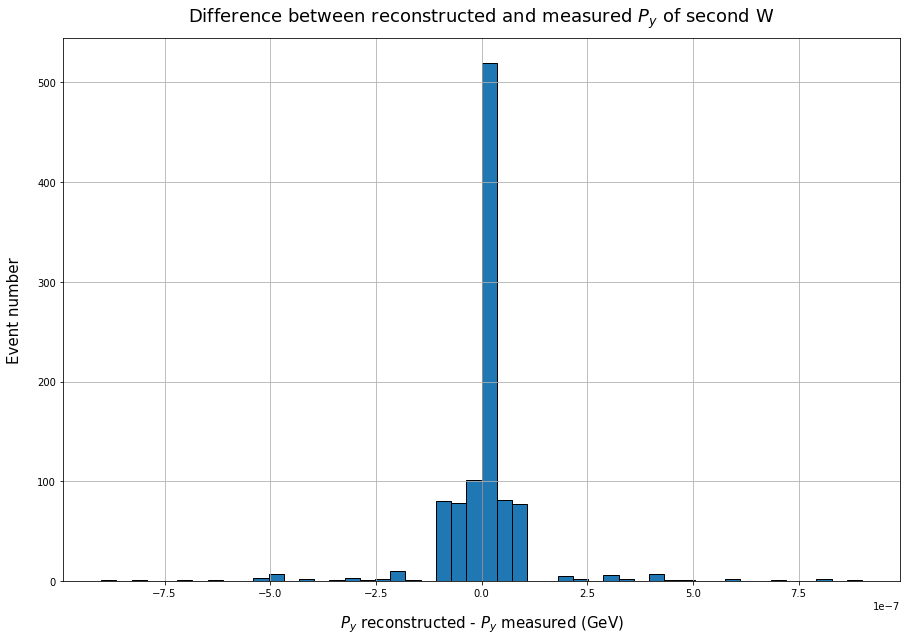

In [22]:
## Difference between measured & reconstructed for second W ##
diffw2y = W2pyrecon-W2pymsure
plt.figure(figsize=[15,10])
plt.hist(diffw2y,bins=50,ec='black')
plt.grid(True)
plt.xlabel("$P_y$ reconstructed - $P_y$ measured (GeV)",labelpad = 15, size= 15)
plt.ylabel("Event number",labelpad = 15, size= 15)
plt.title("Difference between reconstructed and measured $P_y$ of second W",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffw2y**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

The rms of the distribution is  1.1310915557297175e-07


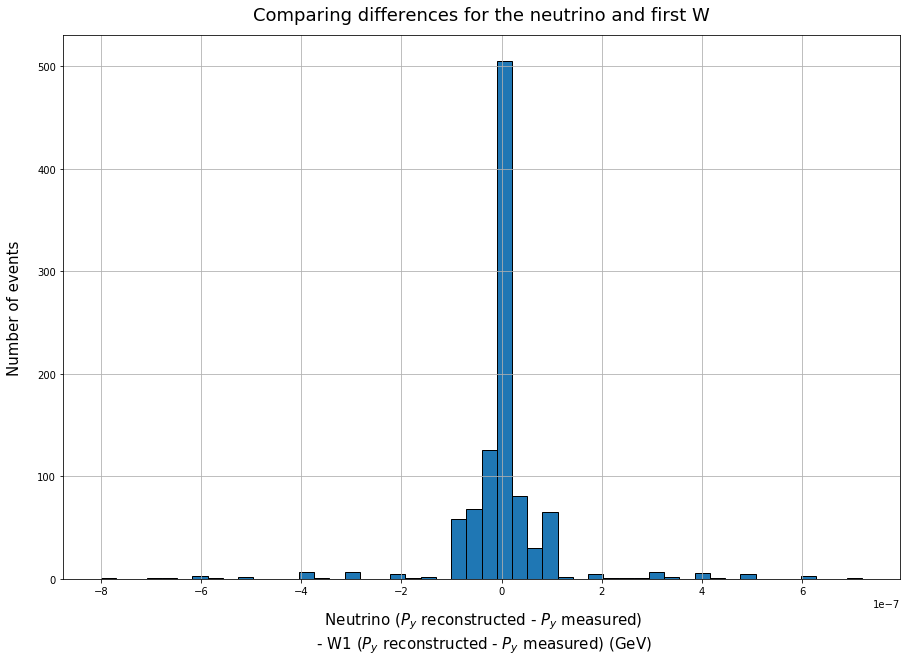

In [23]:
## Comparing diffences for the neutrino and w1##
compare_n_w1 = diffw1y-diffpy
plt.figure(figsize=[15,10])
plt.hist(compare_n_w1,bins=50,ec='black')
plt.grid(True)
plt.xlabel(" Neutrino ($P_y$ reconstructed - $P_y$ measured)\n - W1 ($P_y$ reconstructed - $P_y$ measured) (GeV)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Comparing differences for the neutrino and first W",pad = 15, size= 18);
rms = np.sqrt(np.mean(compare_n_w1**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

#### Interpreting these results
y component seems to be a bit more precise than x component. Again errors in the 7th decimal place.

### Plotting angle differences for the WW boson pairs
This is done at the end of the notebook in section (4)

### Summary of no smearing case

We summarise all the code and the important plots in a few cells.

In [24]:
## assuming -14 is neutrino and 13 is muon and 14/-13 are JETS ##

# Pz
pzrecon = np.empty((0,3), int) #reconstructed
pzmsure = np.empty((0,3), int) #measured
W1pzrecon = np.empty((0,3), int) #w1 reconstructed
W2pzrecon = np.empty((0,3), int) #w2 reconstructed
W1pzmsure = np.empty((0,3), int) #w1 measured
W2pzmsure = np.empty((0,3), int) #w2 measured

for y in range(1,1001):
    
    WWsystem = -1*(globals()[f'event{y}'].Pz[0]+globals()[f'event{y}'].Pz[1])  # WW system Pz = - total Pz of both protons
    ## now we minus the Pz value we know from the total WW system i.e. the muon and jets 
    neutrinoPz = WWsystem - globals()[f'event{y}'].Pz[6] - globals()[f'event{y}'].Pz[7] - globals()[f'event{y}'].Pz[8]
    w1 = neutrinoPz + globals()[f'event{y}'].Pz[6]
    w2 = globals()[f'event{y}'].Pz[7] + globals()[f'event{y}'].Pz[8]
    #print("v_mu Pz=",neutrinoPz,"W1 Pz=",w1,"W2 Pz=",w2,"for event",y)
    
    pzrecon = np.append(pzrecon,neutrinoPz) # filling array with the reconstructed Pz for neutrino
    pzmsure = np.append(pzmsure,globals()[f'event{y}'].Pz[5]) # filling array with the measured Pz for neutrino
    W1pzrecon = np.append(W1pzrecon,w1)
    W2pzrecon = np.append(W2pzrecon,w2)
    W1pzmsure = np.append(W1pzmsure,globals()[f'event{y}'].Pz[3])
    W2pzmsure = np.append(W2pzmsure,globals()[f'event{y}'].Pz[4])

# px
pxrecon = np.empty((0,3), int) #reconstructed
pxmsure = np.empty((0,3), int) #measured
W1pxrecon = np.empty((0,3), int) #w1 reconstructed
W2pxrecon = np.empty((0,3), int) #w2 reconstructed
W1pxmsure = np.empty((0,3), int) #w1 measured
W2pxmsure = np.empty((0,3), int) #w2 measured

for y in range(1,1001):
    
    WWsystem = -1*(globals()[f'event{y}'].Px[0]+globals()[f'event{y}'].Px[1])  # WW system Px = - total Px of both protons
    ## now we minus the Px value we know from the total WW system i.e. the muon and jets 
    neutrinoPx = WWsystem - globals()[f'event{y}'].Px[6] - globals()[f'event{y}'].Px[7] - globals()[f'event{y}'].Px[8]
    w1 = neutrinoPx + globals()[f'event{y}'].Px[6]
    w2 = globals()[f'event{y}'].Px[7] + globals()[f'event{y}'].Px[8]
    #print("v_mu Px=",neutrinoPx,"W1 Px=",w1,"W2 Px=",w2,"for event",y)
    
    pxrecon = np.append(pxrecon,neutrinoPx) # filling array with the reconstructed Px for neutrino
    pxmsure = np.append(pxmsure,globals()[f'event{y}'].Px[5]) # filling array with the measured Px for neutrino
    W1pxrecon = np.append(W1pxrecon,w1)
    W2pxrecon = np.append(W2pxrecon,w2)
    W1pxmsure = np.append(W1pxmsure,globals()[f'event{y}'].Px[3])
    W2pxmsure = np.append(W2pxmsure,globals()[f'event{y}'].Px[4])
#py
pyrecon = np.empty((0,3), int) #reconstructed
pymsure = np.empty((0,3), int) #measured
W1pyrecon = np.empty((0,3), int) #w1 reconstructed
W2pyrecon = np.empty((0,3), int) #w2 reconstructed
W1pymsure = np.empty((0,3), int) #w1 measured
W2pymsure = np.empty((0,3), int) #w2 measured

for y in range(1,1001):
    
    WWsystem = -1*(globals()[f'event{y}'].Py[0]+globals()[f'event{y}'].Py[1])  # WW system Py = - total Py of both protons
    ## now we minus the Py value we know from the total WW system i.e. the muon and jets 
    neutrinoPy = WWsystem - globals()[f'event{y}'].Py[6] - globals()[f'event{y}'].Py[7] - globals()[f'event{y}'].Py[8]
    w1 = neutrinoPy + globals()[f'event{y}'].Py[6]
    w2 = globals()[f'event{y}'].Py[7] + globals()[f'event{y}'].Py[8]
    #print("v_mu Py=",neutrinoPy,"W1 Py=",w1,"W2 Py",w2,"for event",y)
    
    pyrecon = np.append(pyrecon,neutrinoPy) # filling array with the reconstructed Py for neutrino
    pymsure = np.append(pymsure,globals()[f'event{y}'].Py[5]) # filling array with the measured Px for neutrino
    W1pyrecon = np.append(W1pyrecon,w1)
    W2pyrecon = np.append(W2pyrecon,w2)
    W1pymsure = np.append(W1pymsure,globals()[f'event{y}'].Py[3])
    W2pymsure = np.append(W2pymsure,globals()[f'event{y}'].Py[4])

The rmsX of the distribution is  1.0953947720769663e-07
The rmsY of the distribution is  1.0367731176067656e-07
The rmsZ of the distribution is  4.155611806942412e-06


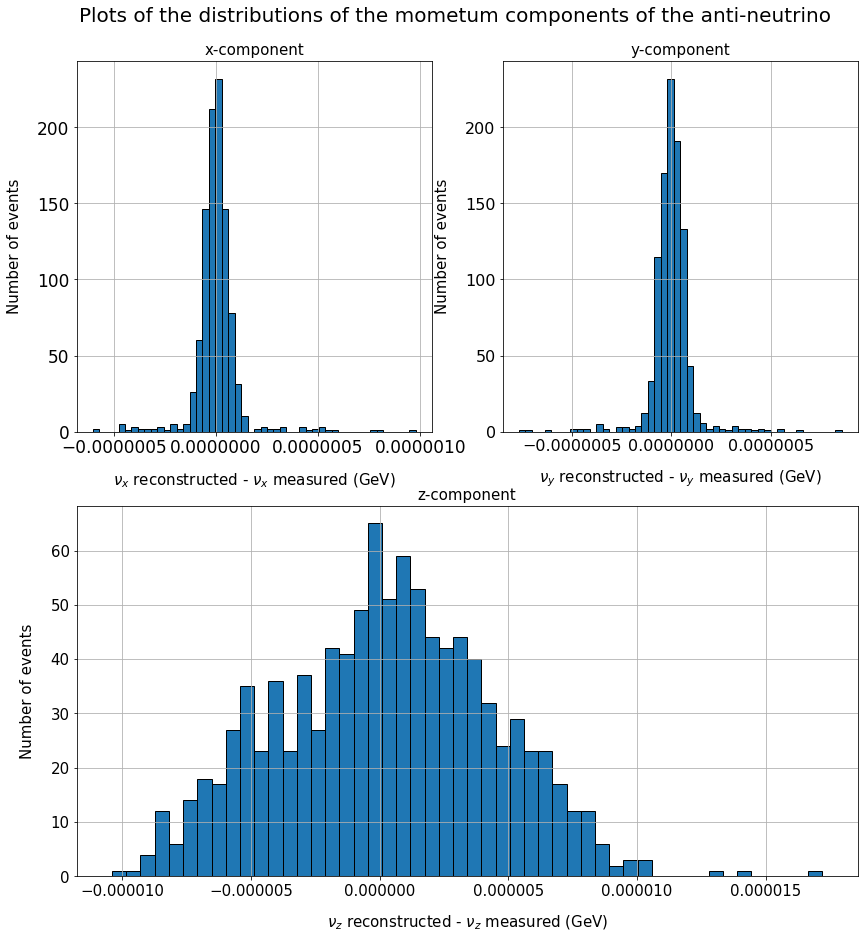

In [25]:
## Difference between measured & reconstructed for anti-neutrino ##
diffz = pzrecon-pzmsure
diffx = pxrecon-pxmsure
diffy = pyrecon-pymsure

fig = plt.figure(figsize=[14,15])
fig.suptitle(r"Plots of the distributions of the mometum components of the anti-neutrino", size= 20, y=0.93)

ax1=fig.add_subplot(221)
ax1.hist(diffx,bins=50, ec='black')
ax1.grid(True)
ax1.tick_params(axis ='both', labelsize=17)
ax1.set_xlabel(r"$\nu_x$ reconstructed - $\nu_x $ measured (GeV)",labelpad = 15, size= 15)
ax1.set_ylabel("Number of events",labelpad = 15, size= 15)
ax1.set_title("x-component", size = 15)
rmsx = np.sqrt(np.mean(diffx**2)) # rms of the distribution
print("The rmsX of the distribution is ", rmsx)

ax2=fig.add_subplot(222)
ax2.hist(diffy,bins=50,ec='black')
ax2.grid(True)
ax2.tick_params(axis ='both', labelsize=16)
ax2.set_xlabel(r"$\nu_y$ reconstructed - $\nu_y $ measured (GeV)",labelpad = 15, size= 15)
ax2.set_ylabel("Number of events",labelpad = 15, size= 15)
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.set_title("y-component", size = 15)
rmsy = np.sqrt(np.mean(diffy**2)) # rms of the distribution
print("The rmsY of the distribution is ", rmsy)

ax3= fig.add_subplot(212)
ax3.hist(diffz,bins = 50, ec="black")
ax3.grid(True)
ax3.tick_params(axis ='both', labelsize=15)
ax3.set_xlabel(r"$\nu_z$ reconstructed - $\nu_z$ measured (GeV)",labelpad = 15, size= 15)
ax3.set_ylabel("Number of events",labelpad = 15, size= 15)
ax3.set_title("z-component", size = 15)
rmsz = np.sqrt(np.mean(diffz**2)) # rms of the distribution
print("The rmsZ of the distribution is ", rmsz)

#plt.savefig("neutrino components.png")

The rmsX of the distribution is  1.2084923049179073e-07
The rmsY of the distribution is  1.2130886398373403e-07
The rmsZ of the distribution is  4.1994528466220276e-06


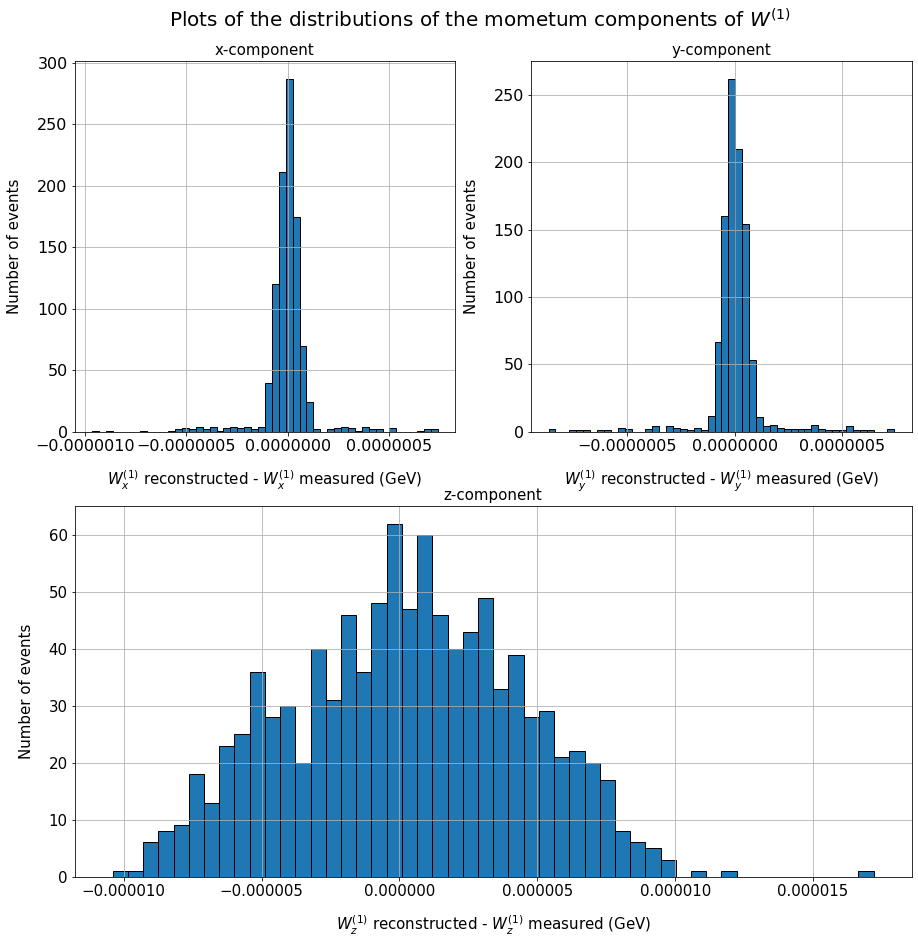

In [26]:
## Difference between measured & reconstructed for W1 boson ##
diffw1z = W1pzrecon-W1pzmsure
diffw1x = W1pxrecon-W1pxmsure
diffw1y = W1pyrecon-W1pymsure

fig = plt.figure(figsize=[15,15])
fig.suptitle(r"Plots of the distributions of the mometum components of $W^{\left(1\right)}$", size= 20, y=0.93)

ax1=fig.add_subplot(221)
ax1.hist(diffw1x,bins=50, ec='black')
ax1.grid(True)
ax1.tick_params(axis ='both', labelsize=16)
ax1.set_xlabel(r"$W^{\left(1\right)}_x$ reconstructed - $W^{\left(1\right)}_x $ measured (GeV)",labelpad = 15, size= 15)
ax1.set_ylabel("Number of events",labelpad = 15, size= 15)
ax1.set_title("x-component", size = 15)
rmsx = np.sqrt(np.mean(diffw1x**2)) # rms of the distribution
print("The rmsX of the distribution is ", rmsx)

ax2=fig.add_subplot(222)
ax2.hist(diffw1y,bins=50,ec='black')
ax2.grid(True)
ax2.tick_params(axis ='both', labelsize=16)
ax2.set_xlabel(r"$W^{\left(1\right)}_y$ reconstructed - $W^{\left(1\right)}_y $ measured (GeV)",labelpad = 15, size= 15)
ax2.set_ylabel("Number of events",labelpad = 15, size= 15)
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.set_title("y-component", size = 15)
rmsy = np.sqrt(np.mean(diffw1y**2)) # rms of the distribution
print("The rmsY of the distribution is ", rmsy)

ax3= fig.add_subplot(212)
ax3.hist(diffw1z,bins = 50, ec="black")
ax3.grid(True)
ax3.tick_params(axis ='both', labelsize=15)
ax3.set_xlabel(r"$W^{\left(1\right)}_z$ reconstructed - $W^{\left(1\right)}_z$ measured (GeV)",labelpad = 15, size= 15)
ax3.set_ylabel("Number of events",labelpad = 15, size= 15)
ax3.set_title("z-component", size = 15)
rmsz = np.sqrt(np.mean(diffw1z**2)) # rms of the distribution
print("The rmsZ of the distribution is ", rmsz)

#plt.savefig("w1 components.png")

The rmsX of the distribution is  1.209723800434899e-07
The rmsY of the distribution is  1.1921412107425746e-07
The rmsZ of the distribution is  1.0142503062317759e-06


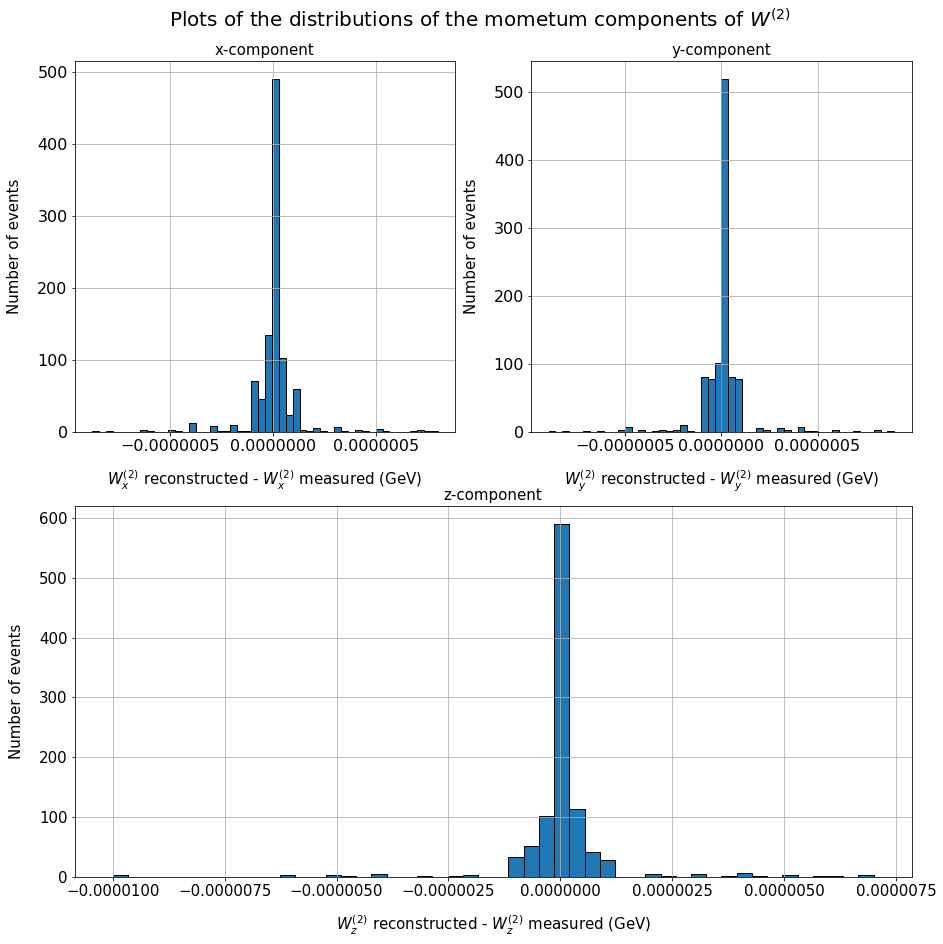

In [27]:
## Difference between measured & reconstructed for W2 boson ##
diffw2z = W2pzrecon-W2pzmsure
diffw2x = W2pxrecon-W2pxmsure
diffw2y = W2pyrecon-W2pymsure

fig = plt.figure(figsize=[15,15])
fig.suptitle(r"Plots of the distributions of the mometum components of $W^{\left(2\right)}$", size= 20, y=0.93)

ax1=fig.add_subplot(221)
ax1.hist(diffw2x,bins=50, ec='black')
ax1.grid(True)
ax1.tick_params(axis ='both', labelsize=16)
ax1.set_xlabel(r"$W^{\left(2\right)}_x$ reconstructed - $W^{\left(2\right)}_x $ measured (GeV)",labelpad = 15, size= 15)
ax1.set_ylabel("Number of events",labelpad = 15, size= 15)
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.set_title("x-component", size = 15)
rmsx = np.sqrt(np.mean(diffw2x**2)) # rms of the distribution
print("The rmsX of the distribution is ", rmsx)

ax2=fig.add_subplot(222)
ax2.hist(diffw2y,bins=50,ec='black')
ax2.grid(True)
ax2.tick_params(axis ='both', labelsize=16)
ax2.set_xlabel(r"$W^{\left(2\right)}_y$ reconstructed - $W^{\left(2\right)}_y $ measured (GeV)",labelpad = 15, size= 15)
ax2.set_ylabel("Number of events",labelpad = 15, size= 15)
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.set_title("y-component", size = 15)
rmsy = np.sqrt(np.mean(diffw2y**2)) # rms of the distribution
print("The rmsY of the distribution is ", rmsy)

ax3= fig.add_subplot(212)
ax3.hist(diffw2z,bins = 50, ec="black")
ax3.grid(True)
ax3.tick_params(axis ='both', labelsize=15)
ax3.set_xlabel(r"$W^{\left(2\right)}_z$ reconstructed - $W^{\left(2\right)}_z$ measured (GeV)",labelpad = 15, size= 15)
ax3.set_ylabel("Number of events",labelpad = 15, size= 15)
ax3.ticklabel_format(useOffset=False, style='plain')
ax3.set_title("z-component", size = 15)
rmsz = np.sqrt(np.mean(diffw2z**2)) # rms of the distribution
print("The rmsZ of the distribution is ", rmsz)

#plt.savefig("w2 components.png")

## 1.5) Checking if the data satisfies momentum and energy conservation


### 1.5.1)Checking if the data fully satisfies momentum conservation


In [28]:
event1

,M.C.N,Px,Py,Pz,E,M
0,2212,-0.121187,-0.107579,6441.689670,6441.689740,9.382720e-01
1,2212,0.002975,0.016852,-6040.814950,6040.815020,9.382720e-01
2,93,0.118212,0.090726,-400.874725,517.495236,3.272625e+02
3,24,-16.241844,-60.069347,-403.188810,415.793605,8.031800e+01
4,-24,16.360056,60.160073,2.314085,101.701632,8.031800e+01
5,-14,13.191932,-42.047960,-347.459313,350.242819,5.981884e-06
6,13,-29.433775,-18.021386,-55.729497,65.550786,1.056600e-01
7,14,0.448229,-2.907942,-29.253903,29.401495,1.590136e-07
8,-13,15.911827,63.068015,31.567989,72.300137,1.056600e-01


In [29]:
## Checking momentum conservation for the px, py & pz components of the event ##

pztotal = np.empty((0,3), int) #reconstructed
pxtotal = np.empty((0,3), int) #reconstructed
pytotal = np.empty((0,3), int) #reconstructed

for y in range(1,1001):
    pz = globals()[f'event{y}'].Pz[0] + globals()[f'event{y}'].Pz[1] +(globals()[f'event{y}'].Pz[3] + globals()[f'event{y}'].Pz[4])
    pz = pz + globals()[f'event{y}'].Pz[5]+globals()[f'event{y}'].Pz[6]+globals()[f'event{y}'].Pz[7]+globals()[f'event{y}'].Pz[8]
    pz = pz - (globals()[f'event{y}'].Pz[3] + globals()[f'event{y}'].Pz[4])
    pztotal = np.append(pztotal,pz)

    py = globals()[f'event{y}'].Py[0] + globals()[f'event{y}'].Py[1] +(globals()[f'event{y}'].Py[3] + globals()[f'event{y}'].Py[4])
    py = py + globals()[f'event{y}'].Py[5]+globals()[f'event{y}'].Py[6]+globals()[f'event{y}'].Py[7]+globals()[f'event{y}'].Py[8]
    py = py - (globals()[f'event{y}'].Py[3] + globals()[f'event{y}'].Py[4])
    pytotal = np.append(pytotal,py)

    px = globals()[f'event{y}'].Px[0] + globals()[f'event{y}'].Px[1] +(globals()[f'event{y}'].Px[3] + globals()[f'event{y}'].Px[4])
    px = px + globals()[f'event{y}'].Px[5]+globals()[f'event{y}'].Px[6]+globals()[f'event{y}'].Px[7]+globals()[f'event{y}'].Px[8]
    px = px - (globals()[f'event{y}'].Px[3] + globals()[f'event{y}'].Px[4])
    pxtotal = np.append(pxtotal,px)   
    

The rmsX of the distribution is  1.0953947732862027e-07
The rmsY of the distribution is  1.0367731189829942e-07
The rmsZ of the distribution is  4.155611806579512e-06


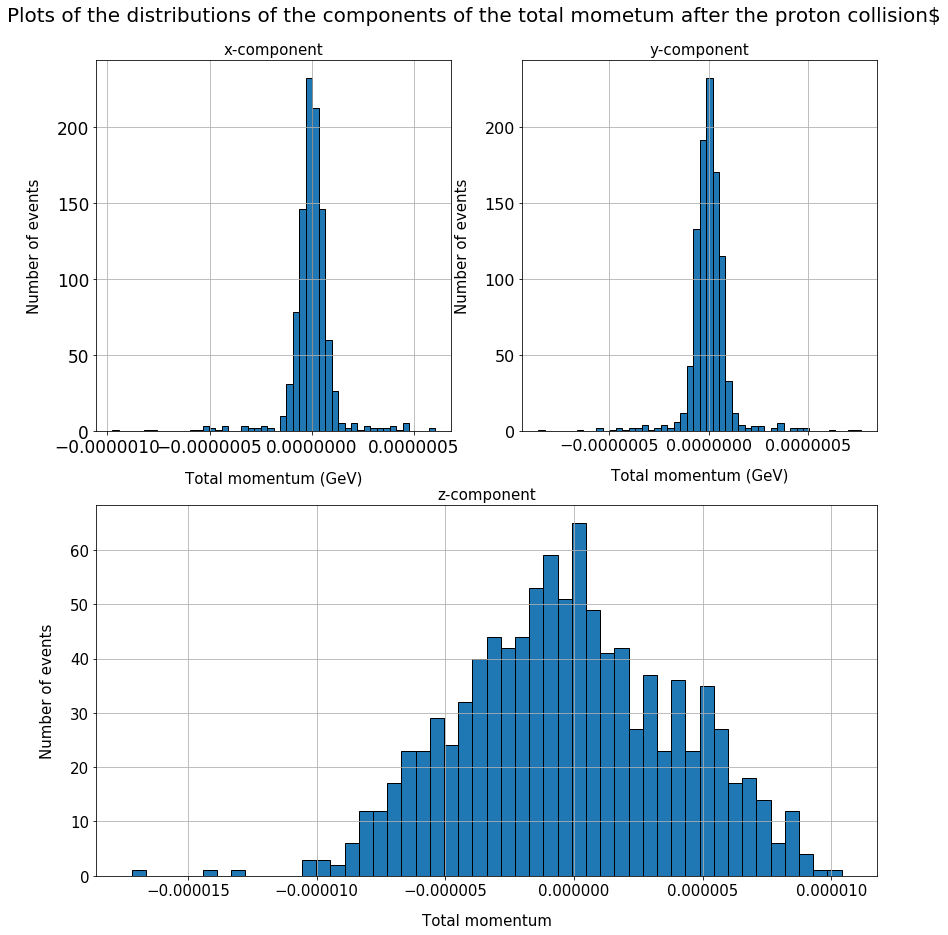

In [30]:
## Momentum conservation for the x, y & z components ##

fig = plt.figure(figsize=[14,15])
fig.suptitle(r"Plots of the distributions of the components of the total mometum after the proton collision$", size= 20, y=0.93)

ax1=fig.add_subplot(221)
ax1.hist(pxtotal,bins=50, ec='black')
ax1.grid(True)
ax1.tick_params(axis ='both', labelsize=17)
ax1.set_xlabel(r"Total momentum (GeV)",labelpad = 15, size= 15)
ax1.set_ylabel("Number of events",labelpad = 15, size= 15)
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.set_title("x-component", size = 15)
rmsx = np.sqrt(np.mean(pxtotal**2)) # rms of the distribution
print("The rmsX of the distribution is ", rmsx)

ax2=fig.add_subplot(222)
ax2.hist(pytotal,bins=50,ec='black')
ax2.grid(True)
ax2.tick_params(axis ='both', labelsize=16)
ax2.set_xlabel(r"Total momentum (GeV)",labelpad = 15, size= 15)
ax2.set_ylabel("Number of events",labelpad = 15, size= 15)
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.set_title("y-component", size = 15)
rmsy = np.sqrt(np.mean(pytotal**2)) # rms of the distribution
print("The rmsY of the distribution is ", rmsy)

ax3= fig.add_subplot(212)
ax3.hist(pztotal,bins = 50, ec="black")
ax3.grid(True)
ax3.tick_params(axis ='both', labelsize=15)
ax3.set_xlabel(r"Total momentum",labelpad = 15, size= 15)
ax3.set_ylabel("Number of events",labelpad = 15, size= 15)
ax3.ticklabel_format(useOffset=False, style='plain')
ax3.set_title("z-component", size = 15)
rmsz = np.sqrt(np.mean(pztotal**2)) # rms of the distribution
print("The rmsZ of the distribution is ", rmsz)

#plt.savefig("conservation of momentum.png")

### 1.5.2) checking if energy is conserved as well


We use the enrgy values of the particles in the data.

In [31]:
event1

,M.C.N,Px,Py,Pz,E,M
0,2212,-0.121187,-0.107579,6441.689670,6441.689740,9.382720e-01
1,2212,0.002975,0.016852,-6040.814950,6040.815020,9.382720e-01
2,93,0.118212,0.090726,-400.874725,517.495236,3.272625e+02
3,24,-16.241844,-60.069347,-403.188810,415.793605,8.031800e+01
4,-24,16.360056,60.160073,2.314085,101.701632,8.031800e+01
5,-14,13.191932,-42.047960,-347.459313,350.242819,5.981884e-06
6,13,-29.433775,-18.021386,-55.729497,65.550786,1.056600e-01
7,14,0.448229,-2.907942,-29.253903,29.401495,1.590136e-07
8,-13,15.911827,63.068015,31.567989,72.300137,1.056600e-01


The rms of the distribution is  4.357039062367529e-06


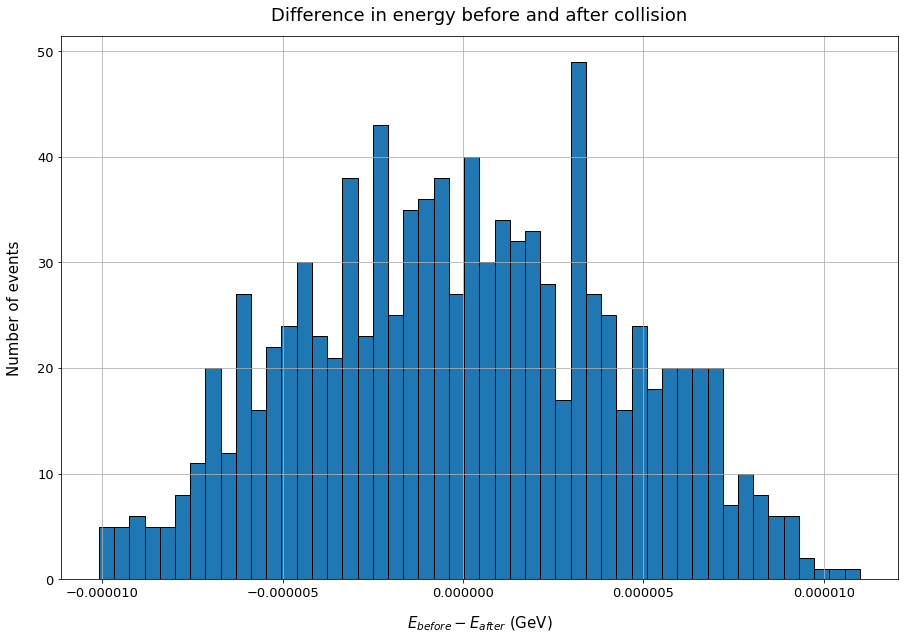

In [32]:
## Checking energy conservation for the Pz of the event ##

E_arr = np.empty((0,3), int) #reconstructed

for y in range(1,1001):
    E_before = 2*6500 
    E_after =  globals()[f'event{y}'].E[0] + globals()[f'event{y}'].E[1]+globals()[f'event{y}'].E[5]+globals()[f'event{y}'].E[6]+globals()[f'event{y}'].E[7]+globals()[f'event{y}'].E[8]
    
    E = E_before - E_after
    E_arr = np.append(E_arr, E)

    
plt.figure(figsize=[15,10])
plt.hist(E_arr,bins=50,ec='black')
plt.grid(True)
plt.xticks(fontsize= 13 )
plt.yticks(fontsize=13)
plt.xlabel(r"$E_{before} - E_{after}$ (GeV)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Difference in energy before and after collision",pad = 15, size= 18);
rms = np.sqrt(np.mean(E_arr**2)) # rms of the distribution
print("The rms of the distribution is ", rms)
plt.savefig("energy conservation.png")

The rms of the distribution is  12997.912131422485


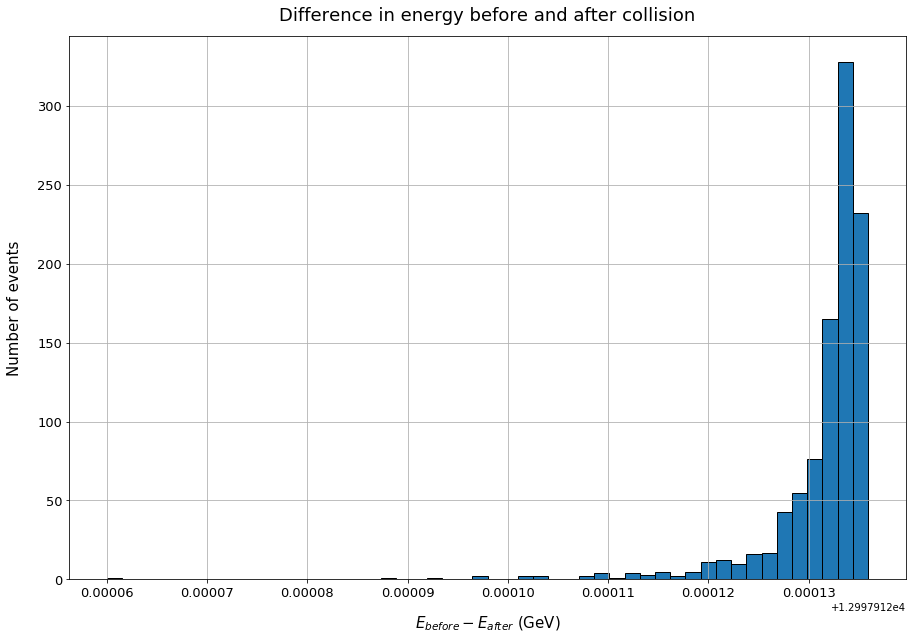

In [33]:
## Checking energy conservation for the Pz of the event ##

E_arr = np.empty((0,3), int) #reconstructed

for y in range(1,1001):
    E_before = 2*6500 
    m_tot= globals()[f'event{y}'].M[0] + globals()[f'event{y}'].M[1]+globals()[f'event{y}'].M[5]+globals()[f'event{y}'].M[6]+globals()[f'event{y}'].M[7]+globals()[f'event{y}'].M[8]
    pz_tot = globals()[f'event{y}'].Pz[0] + globals()[f'event{y}'].Pz[1]+globals()[f'event{y}'].Pz[5]+globals()[f'event{y}'].Pz[6]+globals()[f'event{y}'].Pz[7]+globals()[f'event{y}'].Pz[8]
    px_tot = globals()[f'event{y}'].Px[0] + globals()[f'event{y}'].Px[1]+globals()[f'event{y}'].Px[5]+globals()[f'event{y}'].Px[6]+globals()[f'event{y}'].Px[7]+globals()[f'event{y}'].Px[8]
    py_tot = globals()[f'event{y}'].Py[0] + globals()[f'event{y}'].Py[1]+globals()[f'event{y}'].Py[5]+globals()[f'event{y}'].Py[6]+globals()[f'event{y}'].Py[7]+globals()[f'event{y}'].Py[8]
    c = 1
    p_tot= np.sqrt(pz_tot**2 + px_tot**2 + py_tot**2)
    E_after =  np.sqrt((c**4)*m_tot**2 + (c**2)*p_tot**2)
    
    E = E_before - E_after
    E_arr = np.append(E_arr, E)

    
plt.figure(figsize=[15,10])
plt.hist(E_arr,bins=50,ec='black')
plt.grid(True)
plt.xticks(fontsize= 13 )
plt.yticks(fontsize=13)
plt.xlabel(r"$E_{before} - E_{after}$ (GeV)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Difference in energy before and after collision",pad = 15, size= 18);
rms = np.sqrt(np.mean(E_arr**2)) # rms of the distribution
print("The rms of the distribution is ", rms)
plt.savefig("energy conservation.png")

The rms of the distribution is  12997.912130731058


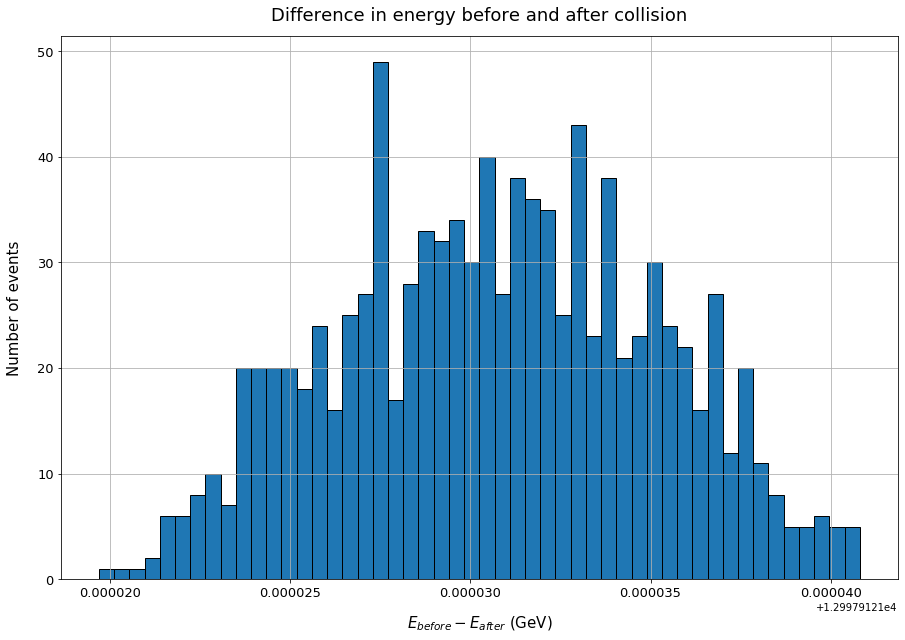

In [34]:
## Checking mass conservation for the Pz of the event ##

E_arr = np.empty((0,3), int) #reconstructed

for y in range(1,1001):
    M_before = 2*6500 
    E_before =  globals()[f'event{y}'].E[0] + globals()[f'event{y}'].E[1]+globals()[f'event{y}'].E[5]+globals()[f'event{y}'].E[6]+globals()[f'event{y}'].E[7]+globals()[f'event{y}'].E[8]
    
    E = E_before - E_after
    E_arr = np.append(E_arr, E)

    
plt.figure(figsize=[15,10])
plt.hist(E_arr,bins=50,ec='black')
plt.grid(True)
plt.xticks(fontsize= 13 )
plt.yticks(fontsize=13)
plt.xlabel(r"$E_{before} - E_{after}$ (GeV)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Difference in energy before and after collision",pad = 15, size= 18);
rms = np.sqrt(np.mean(E_arr**2)) # rms of the distribution
print("The rms of the distribution is ", rms)
plt.savefig("energy conservation.png")

## 2)  Reconstruction with smearing in proton values

In this section we use simple momentum conservation to obtain the momentum components of the anti-neutrino and the two W bosons. However, we introduce a random error to the $P_z$ component of the Protons.This is a random number from a gaussian distribtion with mean equal to 0 and standard deviation 
$$\sigma_{x_i} = 2.5 + {50}\times{x_i} \tag1  $$

where we define $$x_i = \frac{E_b - E_p}{E_p} \tag2$$

where $E_b$ is the energy of the beam (energy of the initial protons) which is 6500GeV and $E_p$ is the energy of the proton after collision. Essentially since the protons have a much larger $P_z$ components than $P_x $ and $P_y$ we can say $$x_i = \frac{6500 - |P_z|}{|P_z|} \tag3$$
where $P_z$ here is the z component of momentm of the proton. Note that we use absolute value as energy is positive and we are interested in the difference in magnitude not the sign of $P_z$.

Note that we only add an error to the z-component so the x and y components remain the same as the previos section in which we didnt have any error.

### Reconstruction for z component


In [35]:
## assuming -14 is neutrino and 13 is muon and 14/-13 are JETS ##

pzrecon = np.empty((0,3), int) #reconstructed
pzmsure = np.empty((0,3), int) #measured
W1pzrecon = np.empty((0,3), int) #w1 reconstructed
W2pzrecon = np.empty((0,3), int) #w2 reconstructed
W1pzmsure = np.empty((0,3), int) #w1 measured
W2pzmsure = np.empty((0,3), int) #w2 measured
sig1_arr = np.empty((0,3), int) #sigma 1 measured
sig2_arr = np.empty((0,3), int) #sigma2 measured

for y in range(1,1001):
    ## Calclating the Pz with error
    protnpz1 = globals()[f'event{y}'].Pz[0] 
    protnpz2 = globals()[f'event{y}'].Pz[1]
    sig1 = 2.5 + 50* ((6500 - abs(protnpz1))/abs(protnpz1))
    sig2 = 2.5 + 50* ((6500 - abs(protnpz2))/abs(protnpz2))
    protnpz1 = protnpz1 + np.random.normal(0,sig1) # adding error
    protnpz2 = protnpz2 + np.random.normal(0,sig2)
    
    ## Doing the recontruction
    WWsystem = -1*(protnpz1+protnpz2)  # WW system Pz = - total Pz of both protons
    ## now we minus the Pz value we know from the total WW system i.e. the muon and jets 
    neutrinoPz = WWsystem - globals()[f'event{y}'].Pz[6] - globals()[f'event{y}'].Pz[7] - globals()[f'event{y}'].Pz[8]
    w1 = neutrinoPz + globals()[f'event{y}'].Pz[6]
    w2 = globals()[f'event{y}'].Pz[7] + globals()[f'event{y}'].Pz[8]
    #print("v_mu Pz=",neutrinoPz,"W1 Pz=",w1,"W2 Pz=",w2,"for event",y)
    
    pzrecon = np.append(pzrecon,neutrinoPz) # filling array with the reconstructed Pz for neutrino
    pzmsure = np.append(pzmsure,globals()[f'event{y}'].Pz[5]) # filling array with the measured Pz for neutrino
    W1pzrecon = np.append(W1pzrecon,w1)
    W2pzrecon = np.append(W2pzrecon,w2)
    W1pzmsure = np.append(W1pzmsure,globals()[f'event{y}'].Pz[3])
    W2pzmsure = np.append(W2pzmsure,globals()[f'event{y}'].Pz[4])
    sig1_arr = np.append(sig1_arr, sig1)
    sig2_arr = np.append(sig2_arr, sig2)

#### Plotting the differences between reconstructed and measured momenta

The rms of the distribution is  12.686476744592824


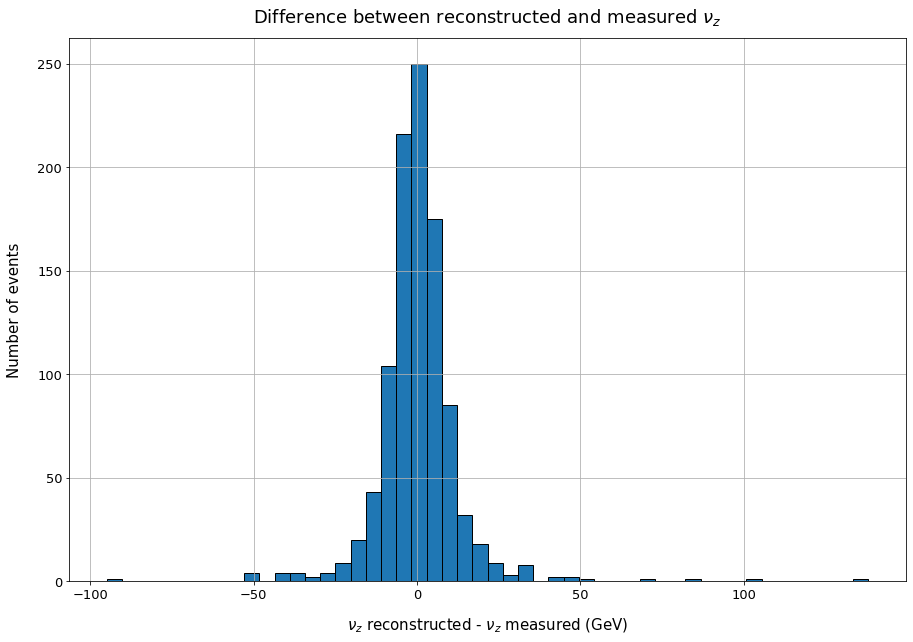

In [36]:
## Difference between measured & reconstructed for neutrino ##
diffpz = pzrecon-pzmsure
plt.figure(figsize=[15,10])
plt.hist(diffpz,bins = 50, ec='black')
plt.grid(True)
plt.xlabel(r"$\nu_z$ reconstructed - $\nu_z$ measured (GeV)",labelpad = 15, size= 15)
plt.xticks(fontsize= 13 )
plt.yticks(fontsize=13)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title(r"Difference between reconstructed and measured $\nu_z$",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffpz**2)) # rms of the distribution
print("The rms of the distribution is ", rms)
plt.savefig("proton smearing.png")

104.67649352928927 93.08413651718017
The rms of the sig1 is  9.171936421615841
rms of sig 2 9.373008383435208


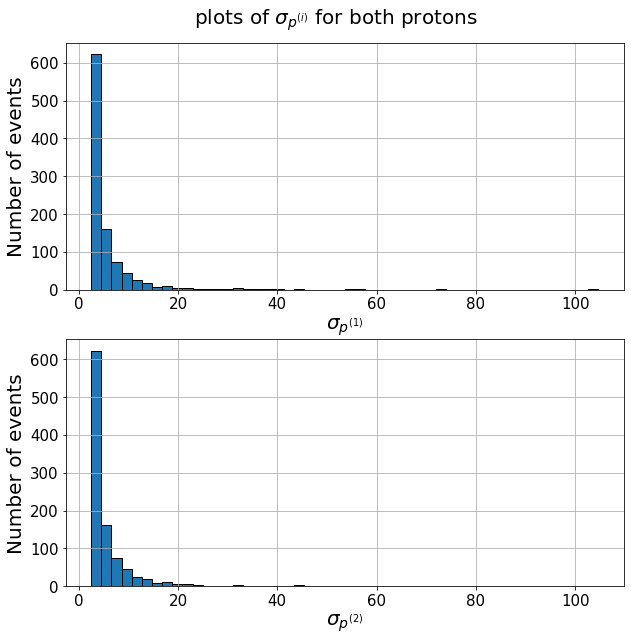

In [37]:
## Difference between measured & reconstructed for neutrino ##

fig, axs = plt.subplots(2,figsize=(10,10))
fig.suptitle(r"plots of $\sigma_{p^{\left(i \right )}}$ for both protons", size= 20, y=0.93)
axs[0].hist(sig1_arr, bins = 50, ec='black')
axs[0].set_xlabel(r"$\sigma_{p^{\left(1 \right )}}$", size = 20)
axs[0].set_ylabel("Number of events", size = 20)
axs[0].grid()
axs[0].tick_params(axis ='both', labelsize=15)

axs[1].hist(sig1_arr, bins = 50, ec='black')
axs[1].set_xlabel(r"$\sigma_{p^{\left(2 \right )}}$", size = 20)
axs[1].set_ylabel("Number of events", size = 20)
axs[1].grid()
axs[1].tick_params(axis ='both', labelsize=15)


rms1 = np.sqrt(np.mean(sig1_arr**2)) # rms of the sig 1
rms2 = np.sqrt(np.mean(sig2_arr**2))
print(np.max(sig1_arr), np.max(sig2_arr))
print("The rms of the sig1 is ", rms1)
print('rms of sig 2',rms2)
plt.savefig("sigma values.png")

The rms of the distribution is  12.686476679742832


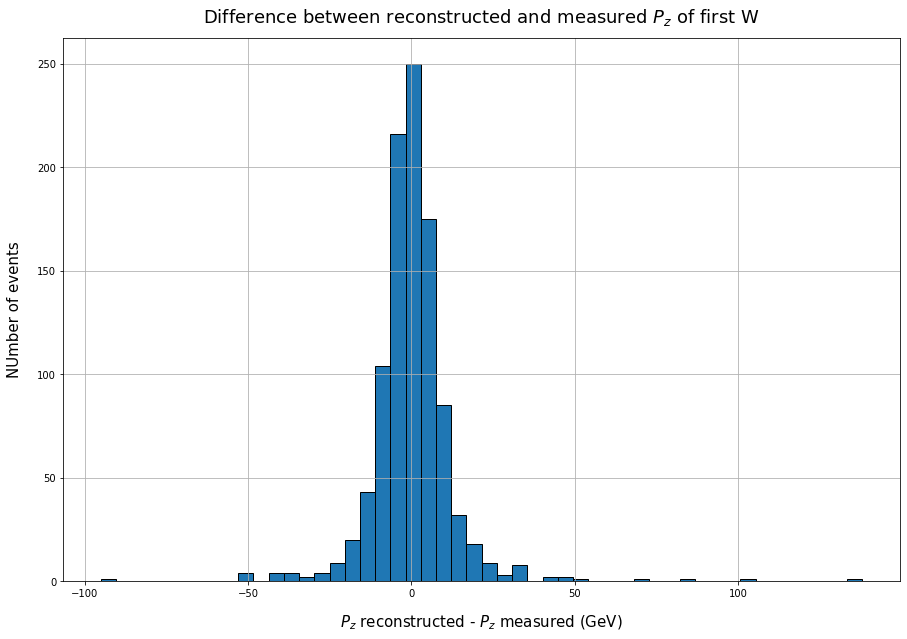

In [38]:
## Difference between measured & reconstructed for first W ##
diffw1z = W1pzrecon-W1pzmsure
plt.figure(figsize=[15,10])
plt.hist(diffw1z,bins = 50, ec="black")
plt.grid(True)
plt.xlabel("$P_z$ reconstructed - $P_z$ measured (GeV)",labelpad = 15, size= 15)
plt.ylabel("NUmber of events",labelpad = 15, size= 15)
plt.title("Difference between reconstructed and measured $P_z$ of first W",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffw1z**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

The rms of the distribution is  1.0142503062317759e-06


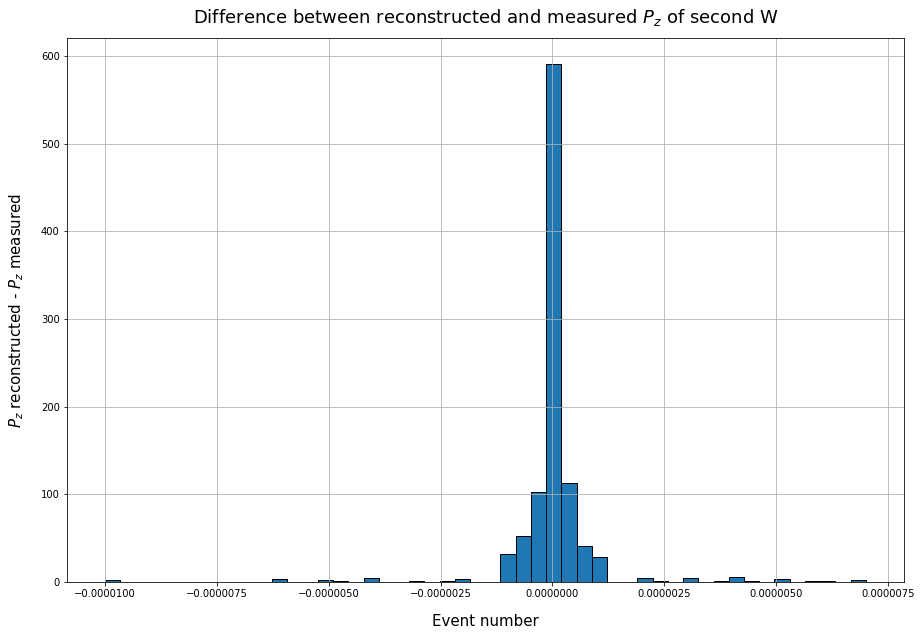

In [39]:
## Difference between measured & reconstructed for second W ##
diffw2z = W2pzrecon-W2pzmsure
plt.figure(figsize=[15,10])
plt.hist(diffw2z,bins=50, ec='black')
plt.grid(True)
plt.ylabel("$P_z$ reconstructed - $P_z$ measured",labelpad = 15, size= 15)
plt.xlabel("Event number",labelpad = 15, size= 15)
plt.title("Difference between reconstructed and measured $P_z$ of second W",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffw2z**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

The rms of the distribution is  1.0932310917377803e-06


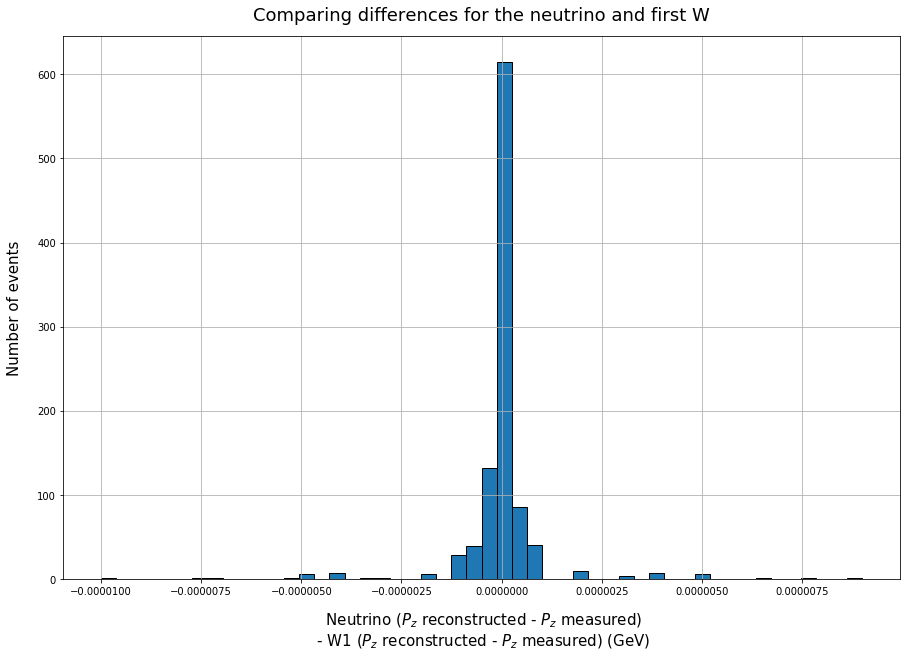

In [40]:
## Comparing diffences for the neutrino and w1##
compare_n_w1 = diffw1z-diffpz
plt.figure(figsize=[15,10])
plt.hist(compare_n_w1,bins=50,ec='black')
plt.grid(True)
plt.xlabel(" Neutrino ($P_z$ reconstructed - $P_z$ measured)\n - W1 ($P_z$ reconstructed - $P_z$ measured) (GeV)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Comparing differences for the neutrino and first W",pad = 15, size= 18);
rms = np.sqrt(np.mean(compare_n_w1**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

#### Interpreting these results

We see that the error in the neutrino and W1 $P_z$ becomes more significant. However since, we still calculate W2 momentum by summing the momenta of the two jets the accuracy is the same as the previous section.

## 3)  Reconstruction with smearing in proton values and in jet values

In this section we use simple momentum conservation to obtain the momentum components of the anti-neutrino and the two W bosons. However, we introduce a random error to the P_z component of the Protons exactly like we did in section (2). However we also add an error to the x,y and z components of the jets. This error is calculated by multiplying the components of the jets by a random number from a gaussian distribution with mean 1 and standard deviation 0.02 ( ie a random error from 0 to 2% added to the values).

We should be careful we don't apply any proton smearing error to the $P_x$ and $P_y$ of the protons.

### Amount of jet smearing

We plot histograms to see the amount of smearing that was added to the momentum components of each jet.

In [41]:
# Jet 1 & Jet 2 calculations

px_diff1 = np.empty((0,3), int)
py_diff1 = np.empty((0,3), int)
pz_diff1 = np.empty((0,3), int)

px_diff2 = np.empty((0,3), int)
py_diff2 = np.empty((0,3), int)
pz_diff2 = np.empty((0,3), int)

for y in range(1,1001):
    px1 = globals()[f'event{y}'].Px[7]*np.random.normal(1,0.02) - globals()[f'event{y}'].Px[7]
    py1 = globals()[f'event{y}'].Py[7]*np.random.normal(1,0.02) - globals()[f'event{y}'].Py[7]
    pz1 = globals()[f'event{y}'].Pz[7]*np.random.normal(1,0.02) - globals()[f'event{y}'].Pz[7]

    px2 = globals()[f'event{y}'].Px[8]*np.random.normal(1,0.02) - globals()[f'event{y}'].Px[8]
    py2 = globals()[f'event{y}'].Py[8]*np.random.normal(1,0.02) - globals()[f'event{y}'].Py[8]
    pz2 = globals()[f'event{y}'].Pz[8]*np.random.normal(1,0.02) - globals()[f'event{y}'].Pz[8]
    
    px_diff1 = np.append(px_diff1,px1)
    py_diff1 = np.append(py_diff1,py1)
    pz_diff1 = np.append(pz_diff1,pz1)
    
    px_diff2 = np.append(px_diff2,px2)
    py_diff2 = np.append(py_diff2,py2)
    pz_diff2 = np.append(pz_diff2,pz2)

The rmsX of the distribution is  0.7650441208688771
The rmsY of the distribution is  0.7769159911488834
The rmsZ of the distribution is  5.8953481124820355


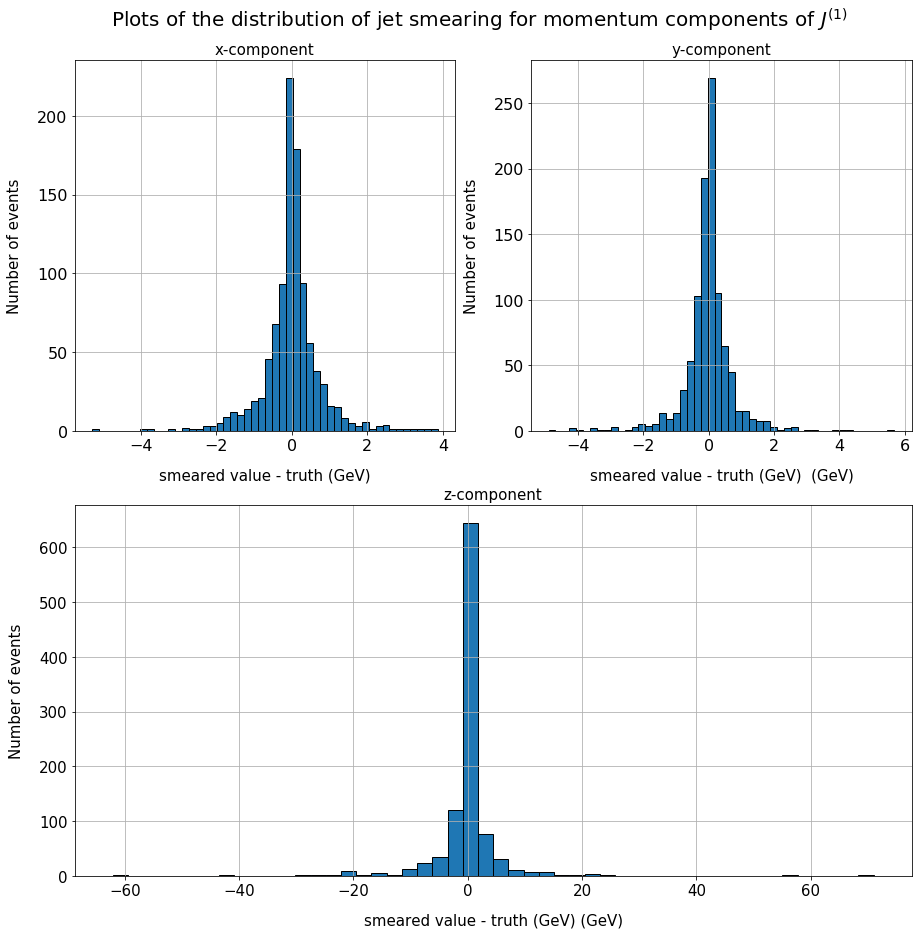

In [42]:
# plots for jet1

## Difference between measured & reconstructed for neutrino ##
diffw1x = px_diff1
diffw1y = py_diff1
diffw1z = pz_diff1

fig = plt.figure(figsize=[15,15])
fig.suptitle(r"Plots of the distribution of jet smearing for momentum components of $J^{\left(1\right)}$", size= 20, y=0.93)

ax1=fig.add_subplot(221)
ax1.hist(diffw1x,bins=50, ec='black')
ax1.grid(True)
ax1.tick_params(axis ='both', labelsize=16)
ax1.set_xlabel(r"smeared value - truth (GeV)",labelpad = 15, size= 15)
ax1.set_ylabel("Number of events",labelpad = 15, size= 15)
ax1.set_title("x-component", size = 15)
rmsx = np.sqrt(np.mean(diffw1x**2)) # rms of the distribution
print("The rmsX of the distribution is ", rmsx)

ax2=fig.add_subplot(222)
ax2.hist(diffw1y,bins=50,ec='black')
ax2.grid(True)
ax2.tick_params(axis ='both', labelsize=16)
ax2.set_xlabel(r"smeared value - truth (GeV)  (GeV)",labelpad = 15, size= 15)
ax2.set_ylabel("Number of events",labelpad = 15, size= 15)
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.set_title("y-component", size = 15)
rmsy = np.sqrt(np.mean(diffw1y**2)) # rms of the distribution
print("The rmsY of the distribution is ", rmsy)

ax3= fig.add_subplot(212)
ax3.hist(diffw1z,bins = 50, ec="black")
ax3.grid(True)
ax3.tick_params(axis ='both', labelsize=15)
ax3.set_xlabel(r"smeared value - truth (GeV) (GeV)",labelpad = 15, size= 15)
ax3.set_ylabel("Number of events",labelpad = 15, size= 15)
ax3.set_title("z-component", size = 15)
rmsz = np.sqrt(np.mean(diffw1z**2)) # rms of the distribution
print("The rmsZ of the distribution is ", rmsz)

#plt.savefig("jet 1 smearing.png")

The rmsX of the distribution is  0.858229261758633
The rmsY of the distribution is  0.8559660670968278
The rmsZ of the distribution is  6.6536679436212935


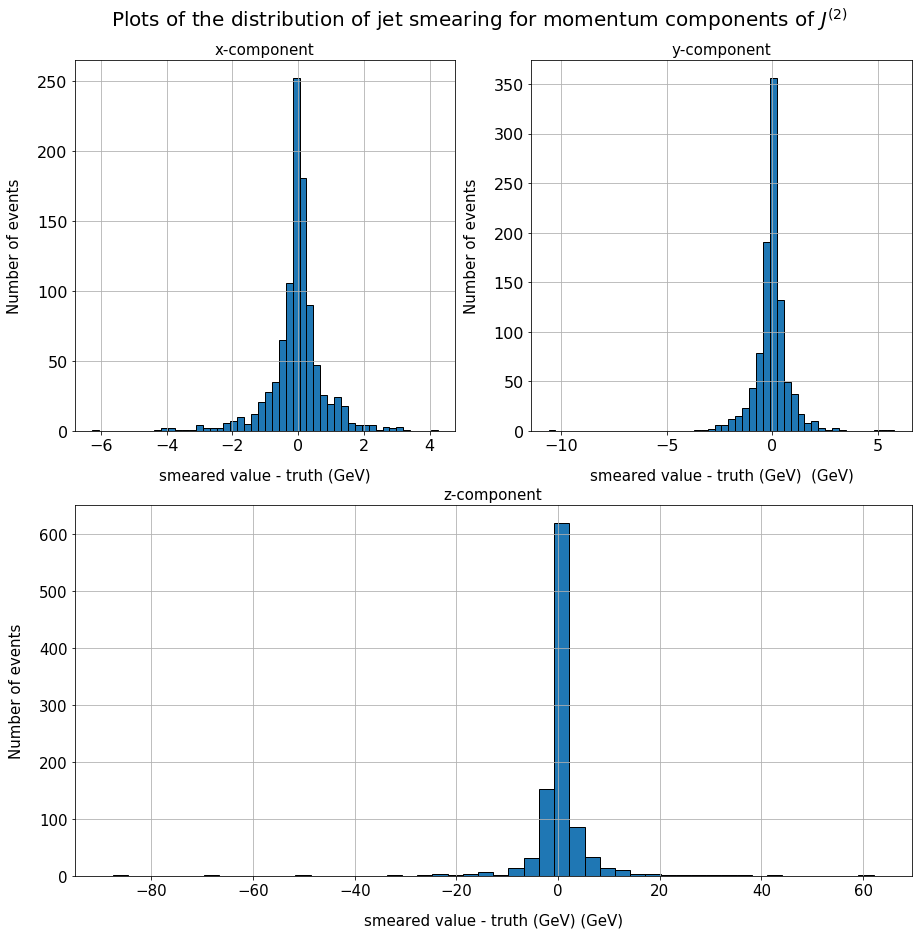

In [43]:
# plots for jet2

## Difference between measured & reconstructed for neutrino ##
diffw1x = px_diff2
diffw1y = py_diff2
diffw1z = pz_diff2

fig = plt.figure(figsize=[15,15])
fig.suptitle(r"Plots of the distribution of jet smearing for momentum components of $J^{\left(2\right)}$", size= 20, y=0.93)

ax1=fig.add_subplot(221)
ax1.hist(diffw1x,bins=50, ec='black')
ax1.grid(True)
ax1.tick_params(axis ='both', labelsize=16)
ax1.set_xlabel(r"smeared value - truth (GeV)",labelpad = 15, size= 15)
ax1.set_ylabel("Number of events",labelpad = 15, size= 15)
ax1.set_title("x-component", size = 15)
rmsx = np.sqrt(np.mean(diffw1x**2)) # rms of the distribution
print("The rmsX of the distribution is ", rmsx)

ax2=fig.add_subplot(222)
ax2.hist(diffw1y,bins=50,ec='black')
ax2.grid(True)
ax2.tick_params(axis ='both', labelsize=16)
ax2.set_xlabel(r"smeared value - truth (GeV)  (GeV)",labelpad = 15, size= 15)
ax2.set_ylabel("Number of events",labelpad = 15, size= 15)
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.set_title("y-component", size = 15)
rmsy = np.sqrt(np.mean(diffw1y**2)) # rms of the distribution
print("The rmsY of the distribution is ", rmsy)

ax3= fig.add_subplot(212)
ax3.hist(diffw1z,bins = 50, ec="black")
ax3.grid(True)
ax3.tick_params(axis ='both', labelsize=15)
ax3.set_xlabel(r"smeared value - truth (GeV) (GeV)",labelpad = 15, size= 15)
ax3.set_ylabel("Number of events",labelpad = 15, size= 15)
ax3.set_title("z-component", size = 15)
rmsz = np.sqrt(np.mean(diffw1z**2)) # rms of the distribution
print("The rmsZ of the distribution is ", rmsz)

#plt.savefig("jet 2 smearing.png")

We see that the smearing is larger for the z components, suggesting that over all the z components of the jets have larger values and hence larger standard deviation values.

### Reconstruction for z component

In [44]:
## assuming -14 is neutrino and 13 is muon and 14/-13 are JETS ##

pzrecon = np.empty((0,3), int) #reconstructed
pzmsure = np.empty((0,3), int) #measured
W1pzrecon = np.empty((0,3), int) #w1 reconstructed
W2pzrecon = np.empty((0,3), int) #w2 reconstructed
W1pzmsure = np.empty((0,3), int) #w1 measured
W2pzmsure = np.empty((0,3), int) #w2 measured

for y in range(1,1001):
    ## Calclating the Pz with error
    protnpz1 = globals()[f'event{y}'].Pz[0] 
    protnpz2 = globals()[f'event{y}'].Pz[1]
    sig1 = 2.5 + 50* ((6500 - abs(protnpz1))/abs(protnpz1))
    sig2 = 2.5 + 50* ((6500 - abs(protnpz2))/abs(protnpz2))
    protnpz1 = protnpz1 + np.random.normal(0,sig1) 
    protnpz2 = protnpz2 + np.random.normal(0,sig2)
      
    ## Doing the recontruction
    WWsystem = -1*(protnpz1+protnpz2)  # WW system Pz = - total Pz of both protons
    ## now we minus the Pz value we know from the total WW system i.e. the muon and jets 
    neutrinoPz = WWsystem - globals()[f'event{y}'].Pz[6] - globals()[f'event{y}'].Pz[7] - globals()[f'event{y}'].Pz[8]
    w1 = neutrinoPz + globals()[f'event{y}'].Pz[6]
    ## with error for the jets
    w2 = globals()[f'event{y}'].Pz[7]*np.random.normal(1,0.02) + globals()[f'event{y}'].Pz[8]*np.random.normal(1,0.02)
    #print("v_mu Pz=",neutrinoPz,"W1 Pz=",w1,"W2 Pz=",w2,"for event",y)
    
    pzrecon = np.append(pzrecon,neutrinoPz) # filling array with the reconstructed Pz for neutrino
    pzmsure = np.append(pzmsure,globals()[f'event{y}'].Pz[5]) # filling array with the measured Pz for neutrino
    W1pzrecon = np.append(W1pzrecon,w1)
    W2pzrecon = np.append(W2pzrecon,w2)
    W1pzmsure = np.append(W1pzmsure,globals()[f'event{y}'].Pz[3])
    W2pzmsure = np.append(W2pzmsure,globals()[f'event{y}'].Pz[4])

In [45]:
event1

,M.C.N,Px,Py,Pz,E,M
0,2212,-0.121187,-0.107579,6441.689670,6441.689740,9.382720e-01
1,2212,0.002975,0.016852,-6040.814950,6040.815020,9.382720e-01
2,93,0.118212,0.090726,-400.874725,517.495236,3.272625e+02
3,24,-16.241844,-60.069347,-403.188810,415.793605,8.031800e+01
4,-24,16.360056,60.160073,2.314085,101.701632,8.031800e+01
5,-14,13.191932,-42.047960,-347.459313,350.242819,5.981884e-06
6,13,-29.433775,-18.021386,-55.729497,65.550786,1.056600e-01
7,14,0.448229,-2.907942,-29.253903,29.401495,1.590136e-07
8,-13,15.911827,63.068015,31.567989,72.300137,1.056600e-01


#### Plotting the differences between reconstructed and measured momenta

The rms of the distribution is  13.366533563862319


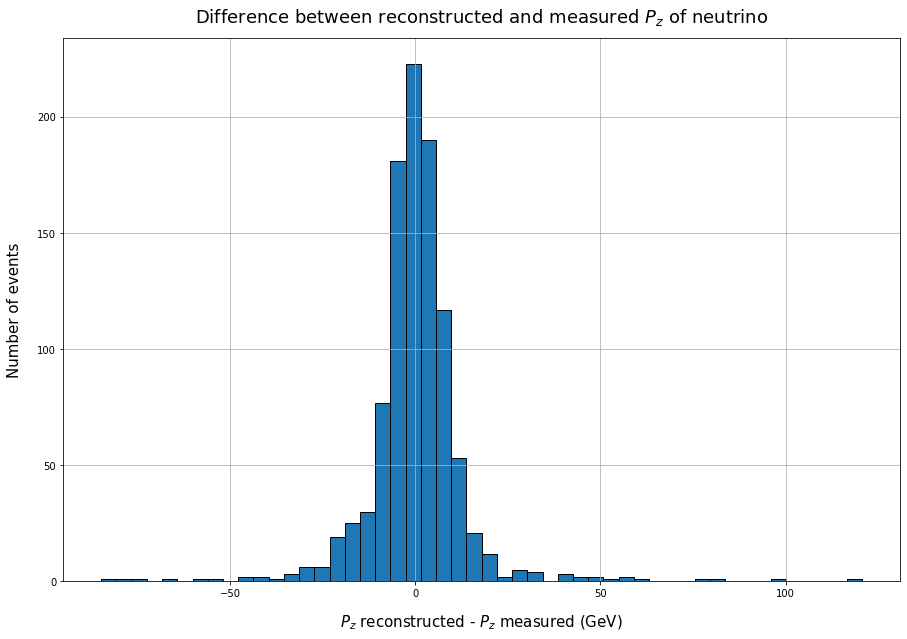

In [46]:
## Difference between measured & reconstructed for neutrino ##
diffpz = pzrecon-pzmsure
plt.figure(figsize=[15,10])
plt.hist(diffpz,bins = 50, ec='black')
plt.grid(True)
plt.xlabel("$P_z$ reconstructed - $P_z$ measured (GeV)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Difference between reconstructed and measured $P_z$ of neutrino",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffpz**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

The rms of the distribution is  13.366533487661926


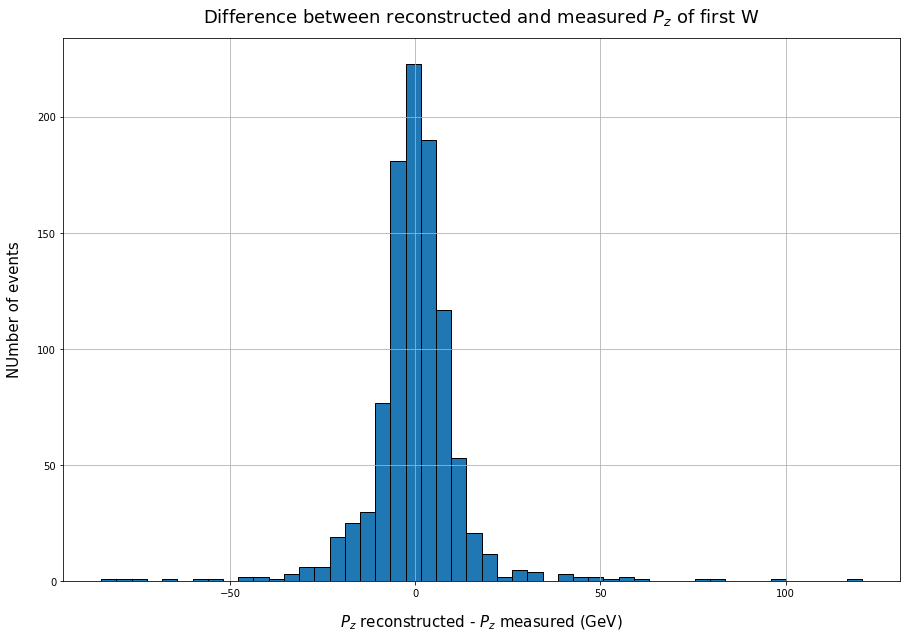

In [47]:
## Difference between measured & reconstructed for first W ##
diffw1z = W1pzrecon-W1pzmsure
plt.figure(figsize=[15,10])
plt.hist(diffw1z,bins = 50, ec="black")
plt.grid(True)
plt.xlabel("$P_z$ reconstructed - $P_z$ measured (GeV)",labelpad = 15, size= 15)
plt.ylabel("NUmber of events",labelpad = 15, size= 15)
plt.title("Difference between reconstructed and measured $P_z$ of first W",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffw1z**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

The rms of the distribution is  8.77222893865101


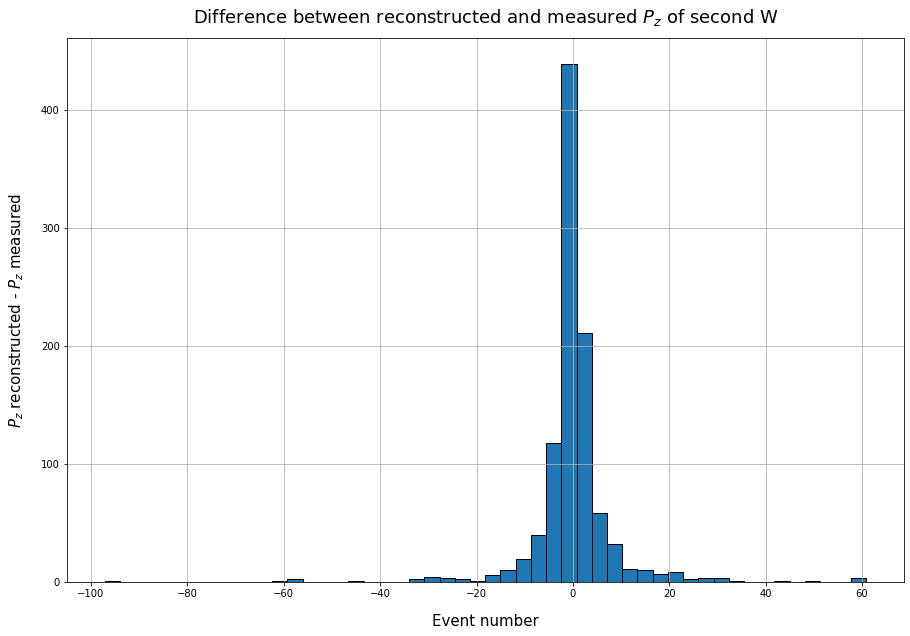

In [48]:
## Difference between measured & reconstructed for second W ##
diffw2z = W2pzrecon-W2pzmsure
plt.figure(figsize=[15,10])
plt.hist(diffw2z,bins=50, ec='black')
plt.grid(True)
plt.ylabel("$P_z$ reconstructed - $P_z$ measured",labelpad = 15, size= 15)
plt.xlabel("Event number",labelpad = 15, size= 15)
plt.title("Difference between reconstructed and measured $P_z$ of second W",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffw2z**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

The rms of the distribution is  1.0932310919863686e-06


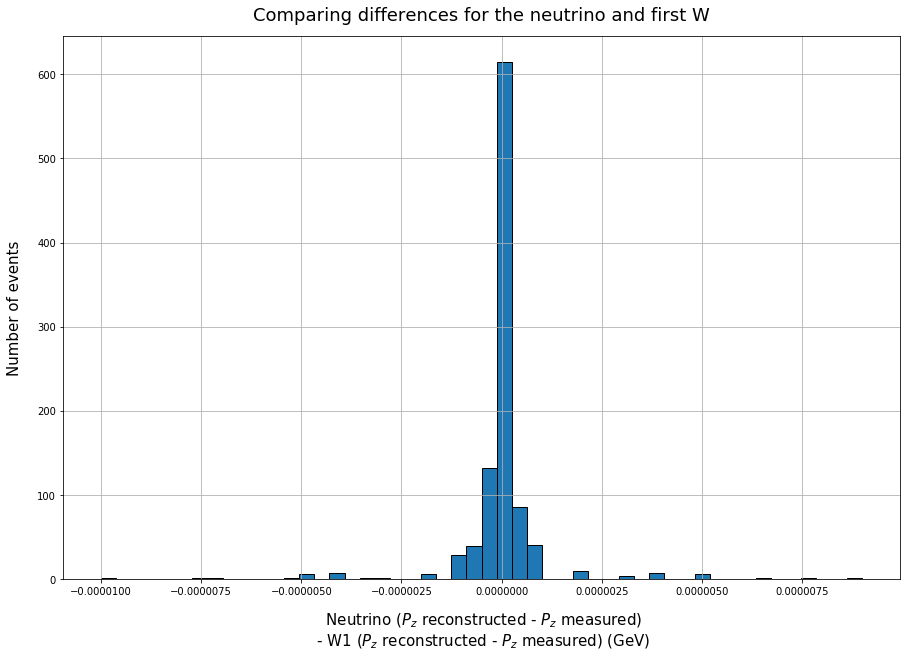

In [49]:
## Comparing diffences for the neutrino and w1##
compare_n_w1 = diffw1z-diffpz
plt.figure(figsize=[15,10])
plt.hist(compare_n_w1,bins=50,ec='black')
plt.grid(True)
plt.xlabel(" Neutrino ($P_z$ reconstructed - $P_z$ measured)\n - W1 ($P_z$ reconstructed - $P_z$ measured) (GeV)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Comparing differences for the neutrino and first W",pad = 15, size= 18);
rms = np.sqrt(np.mean(compare_n_w1**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

#### Interpreting these results
Proton smearing only affected the reconstructed neutrion $P_z$ value and so the $P_z$ of the first W boson. Jet smearing only affects the reconstructed values of the second W boson (for all of $P_x$, $P_y$ and $P_z$).

### Reconstruction for x component

In [50]:
## assuming -14 is neutrino and 13 is muon and 14/-13 are JETS ##

pxrecon = np.empty((0,3), int) #reconstructed
pxmsure = np.empty((0,3), int) #measured
W1pxrecon = np.empty((0,3), int) #w1 reconstructed
W2pxrecon = np.empty((0,3), int) #w2 reconstructed
W1pxmsure = np.empty((0,3), int) #w1 measured
W2pxmsure = np.empty((0,3), int) #w2 measured

for y in range(1,1001):

    protnpx1 = globals()[f'event{y}'].Px[0] 
    protnpx2 = globals()[f'event{y}'].Px[1]
    WWsystem = -1*(protnpx1+protnpx2)  # WW system Px = - total Px of both protons
    ## now we minus the Pz value we know from the total WW system i.e. the muon and jets 
    neutrinoPx = WWsystem - globals()[f'event{y}'].Px[6] - globals()[f'event{y}'].Px[7] - globals()[f'event{y}'].Px[8]
    w1 = neutrinoPx + globals()[f'event{y}'].Px[6]
    ## with error for the jets
    w2 = globals()[f'event{y}'].Px[7]*np.random.normal(1,0.02) + globals()[f'event{y}'].Px[8]*np.random.normal(1,0.02)
    #print("v_mu Px=",neutrinoPx,"W1 Px=",w1,"W2 Px=",w2,"for event",y)
    
    pxrecon = np.append(pxrecon,neutrinoPx) # filling array with the reconstructed Pz for neutrino
    pxmsure = np.append(pxmsure,globals()[f'event{y}'].Px[5]) # filling array with the measured Pz for neutrino
    W1pxrecon = np.append(W1pxrecon,w1)
    W2pxrecon = np.append(W2pxrecon,w2)
    W1pxmsure = np.append(W1pxmsure,globals()[f'event{y}'].Px[3])
    W2pxmsure = np.append(W2pxmsure,globals()[f'event{y}'].Px[4])

#### Plotting the differences between reconstructed and measured momenta

The rms of the distribution is  1.0953947720769663e-07


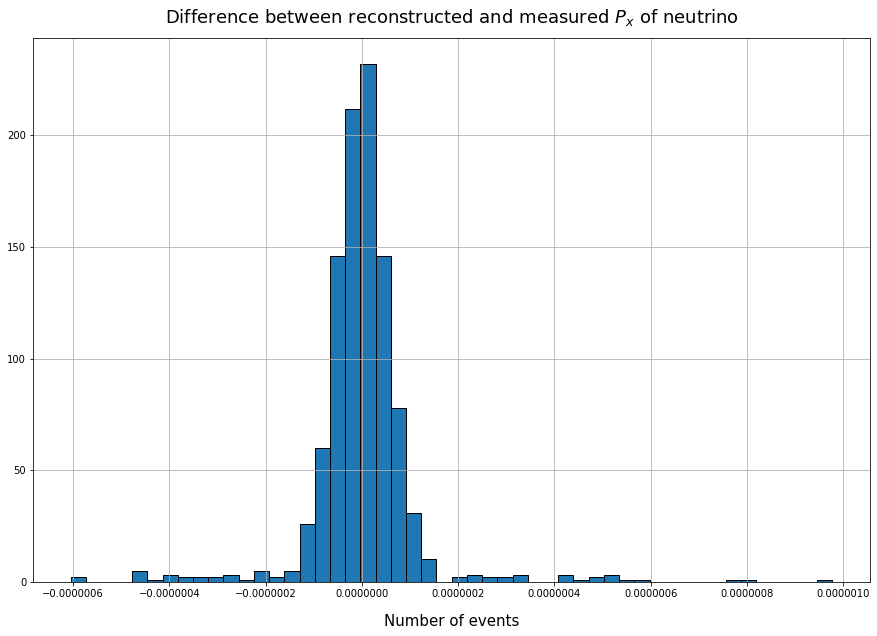

In [51]:
## Difference between measured & reconstructed for neutrino ##
diffpx = pxrecon-pxmsure
plt.figure(figsize=[15,10])
plt.hist(diffpx,bins=50,ec="black")
plt.grid(True)
plt.xlabel("$P_x$ reconstructed - $P_x$ measured (Gev)",labelpad = 15, size= 15)
plt.xlabel("Number of events",labelpad = 15, size= 15)
plt.title("Difference between reconstructed and measured $P_x$ of neutrino",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffpx**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

The rms of the distribution is  1.2084923049179073e-07


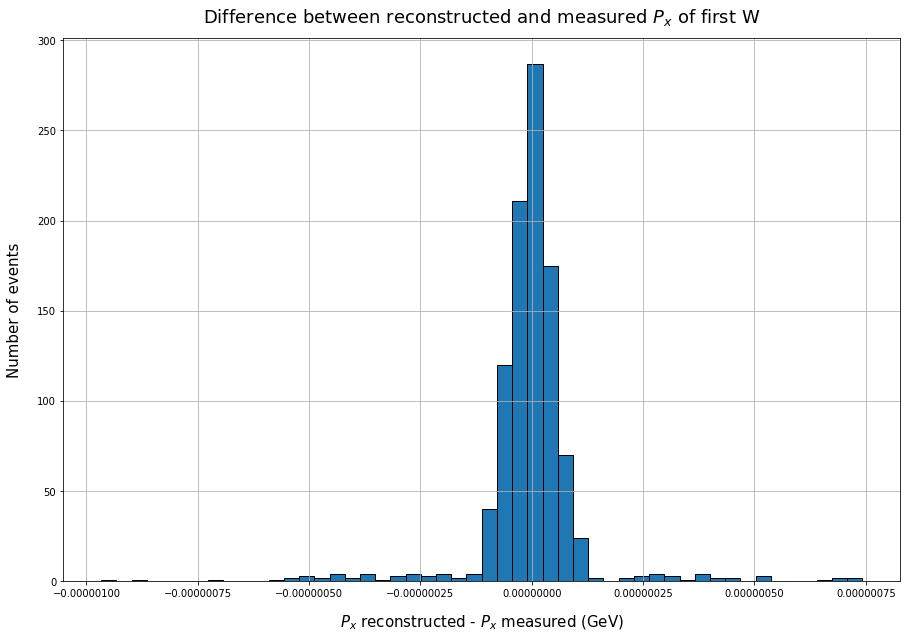

In [52]:
## Difference between measured & reconstructed for first W ##
diffw1x = W1pxrecon-W1pxmsure
plt.figure(figsize=[15,10])
plt.hist(diffw1x,bins=50, ec='black')
plt.grid(True)
plt.xlabel("$P_x$ reconstructed - $P_x$ measured (GeV)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Difference between reconstructed and measured $P_x$ of first W",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffw1x**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

The rms of the distribution is  1.1949495205720628


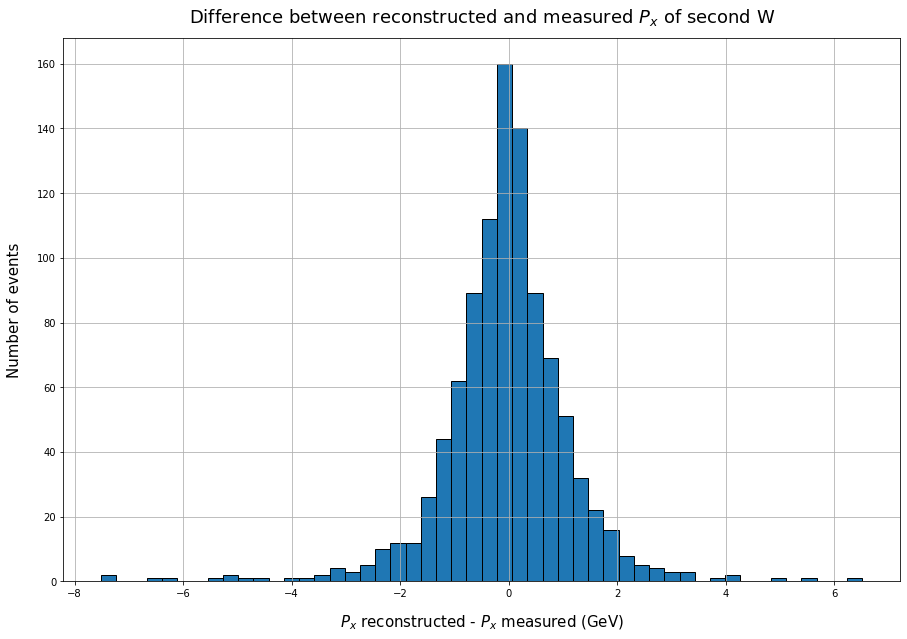

In [53]:
## Difference between measured & reconstructed for second W ##
diffw2x = W2pxrecon-W2pxmsure
plt.figure(figsize=[15,10])
plt.hist(diffw2x,bins=50, ec='black')
plt.grid(True)
plt.xlabel("$P_x$ reconstructed - $P_x$ measured (GeV)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Difference between reconstructed and measured $P_x$ of second W",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffw2x**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

The rms of the distribution is  1.275110303293441e-07


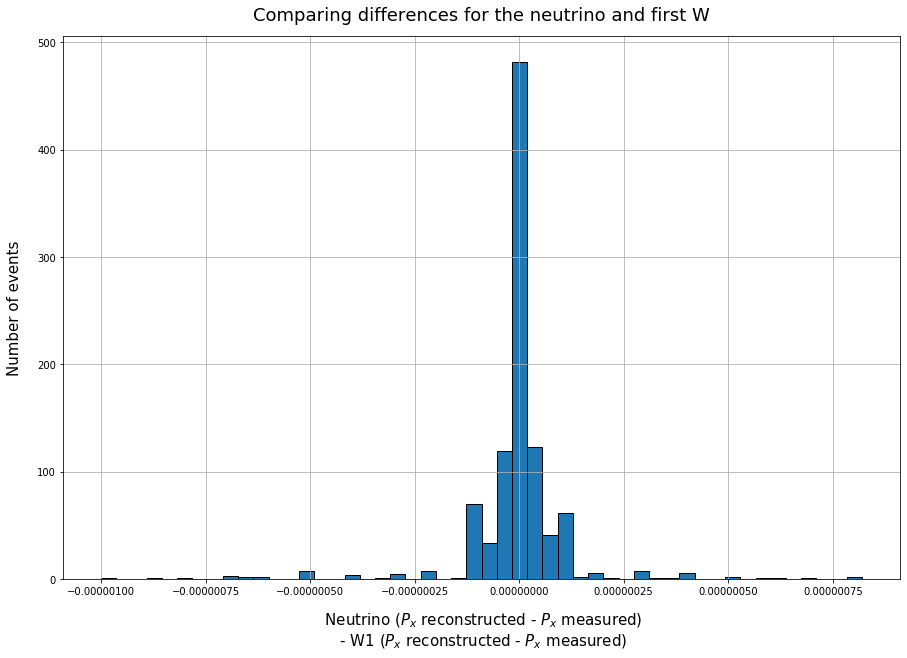

In [54]:
## Comparing diffences for the neutrino and w1##
compare_n_w1 = diffw1x-diffpx
plt.figure(figsize=[15,10])
plt.hist(compare_n_w1,bins=50, ec='black')
plt.grid(True)
plt.xlabel(" Neutrino ($P_x$ reconstructed - $P_x$ measured)\n - W1 ($P_x$ reconstructed - $P_x$ measured)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Comparing differences for the neutrino and first W",pad = 15, size= 18);
rms = np.sqrt(np.mean(compare_n_w1**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

### Reconstruction for y component

In [55]:
## assuming -14 is neutrino and 13 is muon and 14/-13 are JETS ##

pyrecon = np.empty((0,3), int) #reconstructed
pymsure = np.empty((0,3), int) #measured
W1pyrecon = np.empty((0,3), int) #w1 reconstructed
W2pyrecon = np.empty((0,3), int) #w2 reconstructed
W1pymsure = np.empty((0,3), int) #w1 measured
W2pymsure = np.empty((0,3), int) #w2 measured

for y in range(1,1001):

    protnpy1 = globals()[f'event{y}'].Py[0] 
    protnpy2 = globals()[f'event{y}'].Py[1]
    WWsystem = -1*(protnpy1+protnpy2)  # WW system Py = - total Py of both protons
    ## now we minus the Py value we know from the total WW system i.e. the muon and jets 
    neutrinoPy = WWsystem - globals()[f'event{y}'].Py[6] - globals()[f'event{y}'].Py[7] - globals()[f'event{y}'].Py[8]
    w1 = neutrinoPy + globals()[f'event{y}'].Py[6]
    ## with error for the jets
    w2 = globals()[f'event{y}'].Py[7]*np.random.normal(1,0.02) + globals()[f'event{y}'].Py[8]*np.random.normal(1,0.02)
    #print("v_mu Py=",neutrinoPy,"W1 Py=",w1,"W2 Py=",w2,"for event",y)
    
    pyrecon = np.append(pyrecon,neutrinoPy) # filling array with the reconstructed Pz for neutrino
    pymsure = np.append(pymsure,globals()[f'event{y}'].Py[5]) # filling array with the measured Pz for neutrino
    W1pyrecon = np.append(W1pyrecon,w1)
    W2pyrecon = np.append(W2pyrecon,w2)
    W1pymsure = np.append(W1pymsure,globals()[f'event{y}'].Py[3])
    W2pymsure = np.append(W2pymsure,globals()[f'event{y}'].Py[4])

#### Plotting the differences between reconstructed and measured momenta

The rms of the distribution is  1.0367731176067656e-07


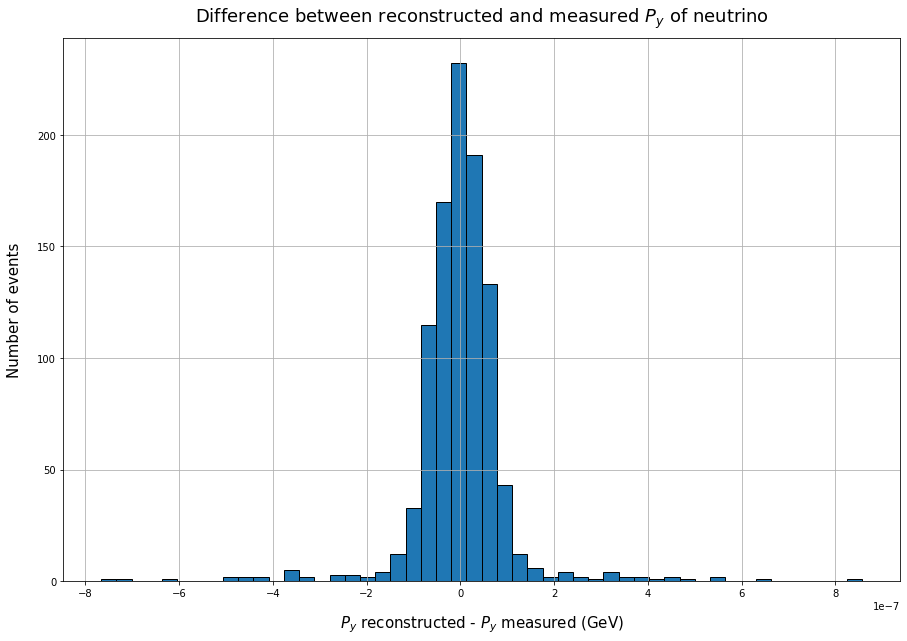

In [56]:
## Difference between measured & reconstructed for neutrino ##
diffpy = pyrecon-pymsure
plt.figure(figsize=[15,10])
plt.hist(diffpy,bins=50,ec='black')
plt.grid(True)
plt.xlabel("$P_y$ reconstructed - $P_y$ measured (GeV)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Difference between reconstructed and measured $P_y$ of neutrino",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffpy**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

The rms of the distribution is  1.2130886398373403e-07


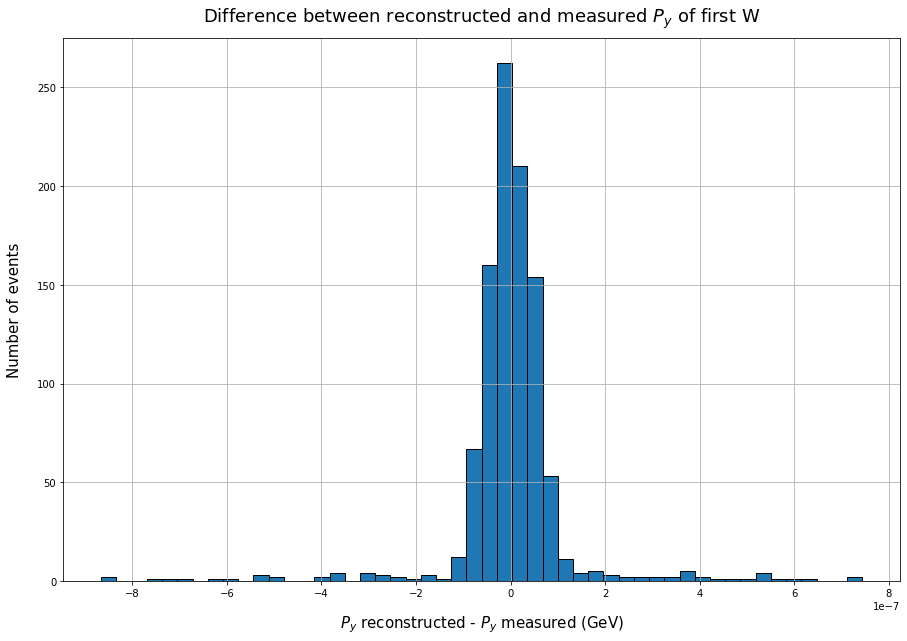

In [57]:
## Difference between measured & reconstructed for first W ##
diffw1y = W1pyrecon-W1pymsure
plt.figure(figsize=[15,10])
plt.hist(diffw1y,bins=50,ec='black')
plt.grid(True)
plt.xlabel("$P_y$ reconstructed - $P_y$ measured (GeV)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Difference between reconstructed and measured $P_y$ of first W",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffw1y**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

The rms of the distribution is  1.1699590313722594


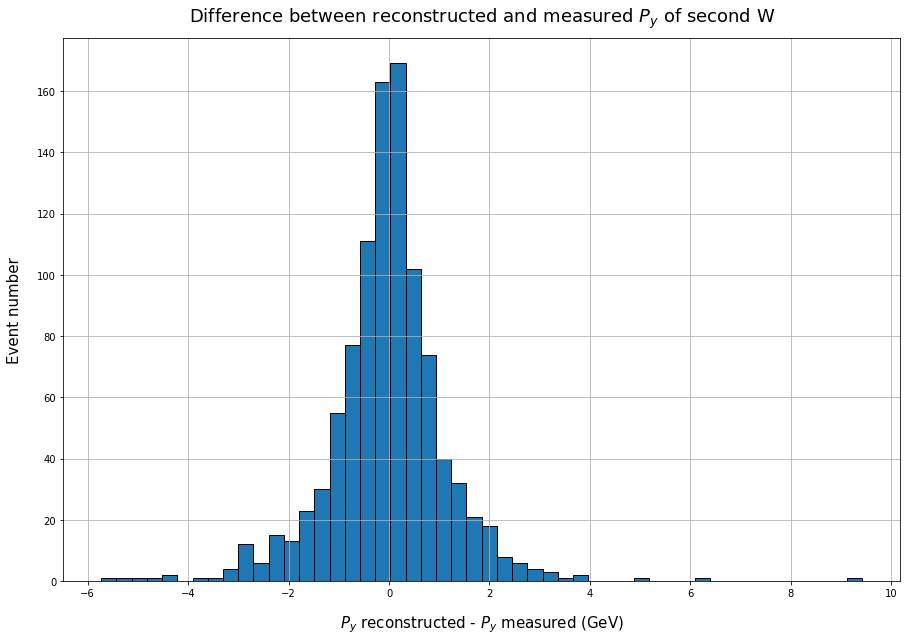

In [58]:
## Difference between measured & reconstructed for second W ##
diffw2y = W2pyrecon-W2pymsure
plt.figure(figsize=[15,10])
plt.hist(diffw2y,bins=50,ec='black')
plt.grid(True)
plt.xlabel("$P_y$ reconstructed - $P_y$ measured (GeV)",labelpad = 15, size= 15)
plt.ylabel("Event number",labelpad = 15, size= 15)
plt.title("Difference between reconstructed and measured $P_y$ of second W",pad = 15, size= 18);
rms = np.sqrt(np.mean(diffw2y**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

The rms of the distribution is  1.1310915557297175e-07


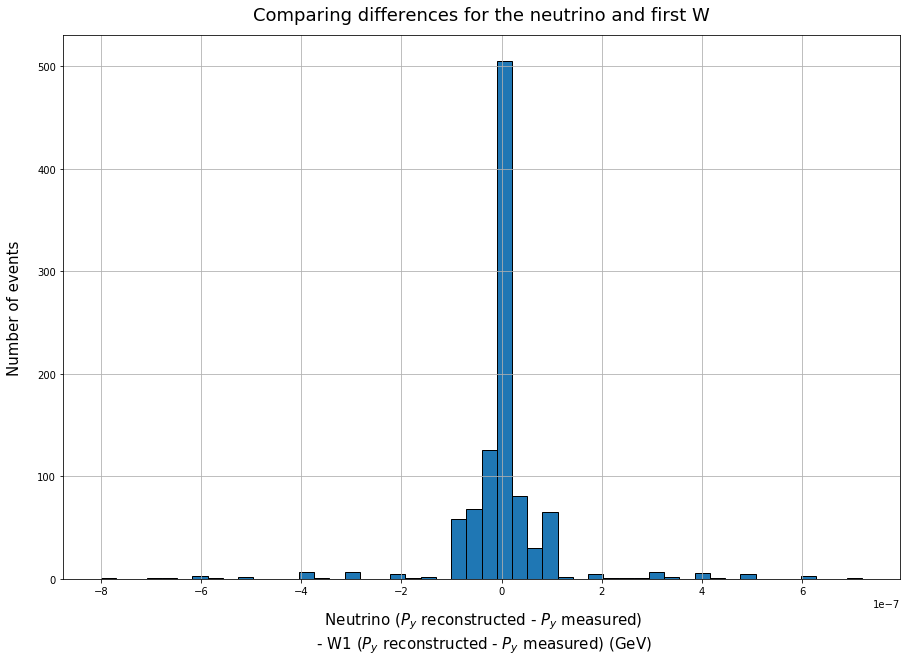

In [59]:
## Comparing diffences for the neutrino and w1##
compare_n_w1 = diffw1y-diffpy
plt.figure(figsize=[15,10])
plt.hist(compare_n_w1,bins=50,ec='black')
plt.grid(True)
plt.xlabel(" Neutrino ($P_y$ reconstructed - $P_y$ measured)\n - W1 ($P_y$ reconstructed - $P_y$ measured) (GeV)",labelpad = 15, size= 15)
plt.ylabel("Number of events",labelpad = 15, size= 15)
plt.title("Comparing differences for the neutrino and first W",pad = 15, size= 18);
rms = np.sqrt(np.mean(compare_n_w1**2)) # rms of the distribution
print("The rms of the distribution is ", rms)

### Smearing section summary

We summarise the whole section with the code and important plots in a few cells.

In [60]:
## assuming -14 is neutrino and 13 is muon and 14/-13 are JETS ##

#pz
pzrecon = np.empty((0,3), int) #reconstructed
pzmsure = np.empty((0,3), int) #measured
W1pzrecon = np.empty((0,3), int) #w1 reconstructed
W2pzrecon = np.empty((0,3), int) #w2 reconstructed
W1pzmsure = np.empty((0,3), int) #w1 measured
W2pzmsure = np.empty((0,3), int) #w2 measured

for y in range(1,1001):
    ## Calclating the Pz with error
    protnpz1 = globals()[f'event{y}'].Pz[0] 
    protnpz2 = globals()[f'event{y}'].Pz[1]
    sig1 = 2.5 + 50* ((6500 - abs(protnpz1))/abs(protnpz1))
    sig2 = 2.5 + 50* ((6500 - abs(protnpz2))/abs(protnpz2))
    protnpz1 = protnpz1 + np.random.normal(0,sig1) 
    protnpz2 = protnpz2 + np.random.normal(0,sig2)
      
    ## Doing the recontruction
    WWsystem = -1*(protnpz1+protnpz2)  # WW system Pz = - total Pz of both protons
    ## now we minus the Pz value we know from the total WW system i.e. the muon and jets 
    neutrinoPz = WWsystem - globals()[f'event{y}'].Pz[6] - globals()[f'event{y}'].Pz[7] - globals()[f'event{y}'].Pz[8]
    w1 = neutrinoPz + globals()[f'event{y}'].Pz[6]
    ## with error for the jets
    w2 = globals()[f'event{y}'].Pz[7]*np.random.normal(1,0.02) + globals()[f'event{y}'].Pz[8]*np.random.normal(1,0.02)
    #print("v_mu Pz=",neutrinoPz,"W1 Pz=",w1,"W2 Pz=",w2,"for event",y)
    
    pzrecon = np.append(pzrecon,neutrinoPz) # filling array with the reconstructed Pz for neutrino
    pzmsure = np.append(pzmsure,globals()[f'event{y}'].Pz[5]) # filling array with the measured Pz for neutrino
    W1pzrecon = np.append(W1pzrecon,w1)
    W2pzrecon = np.append(W2pzrecon,w2)
    W1pzmsure = np.append(W1pzmsure,globals()[f'event{y}'].Pz[3])
    W2pzmsure = np.append(W2pzmsure,globals()[f'event{y}'].Pz[4])

    #px
pxrecon = np.empty((0,3), int) #reconstructed
pxmsure = np.empty((0,3), int) #measured
W1pxrecon = np.empty((0,3), int) #w1 reconstructed
W2pxrecon = np.empty((0,3), int) #w2 reconstructed
W1pxmsure = np.empty((0,3), int) #w1 measured
W2pxmsure = np.empty((0,3), int) #w2 measured

for y in range(1,1001):

    protnpx1 = globals()[f'event{y}'].Px[0] 
    protnpx2 = globals()[f'event{y}'].Px[1]
    WWsystem = -1*(protnpx1+protnpx2)  # WW system Px = - total Px of both protons
    ## now we minus the Pz value we know from the total WW system i.e. the muon and jets 
    neutrinoPx = WWsystem - globals()[f'event{y}'].Px[6] - globals()[f'event{y}'].Px[7] - globals()[f'event{y}'].Px[8]
    w1 = neutrinoPx + globals()[f'event{y}'].Px[6]
    ## with error for the jets
    w2 = globals()[f'event{y}'].Px[7]*np.random.normal(1,0.02) + globals()[f'event{y}'].Px[8]*np.random.normal(1,0.02)
    #print("v_mu Px=",neutrinoPx,"W1 Px=",w1,"W2 Px=",w2,"for event",y)
    
    pxrecon = np.append(pxrecon,neutrinoPx) # filling array with the reconstructed Pz for neutrino
    pxmsure = np.append(pxmsure,globals()[f'event{y}'].Px[5]) # filling array with the measured Pz for neutrino
    W1pxrecon = np.append(W1pxrecon,w1)
    W2pxrecon = np.append(W2pxrecon,w2)
    W1pxmsure = np.append(W1pxmsure,globals()[f'event{y}'].Px[3])
    W2pxmsure = np.append(W2pxmsure,globals()[f'event{y}'].Px[4])
    

pyrecon = np.empty((0,3), int) #reconstructed
pymsure = np.empty((0,3), int) #measured
W1pyrecon = np.empty((0,3), int) #w1 reconstructed
W2pyrecon = np.empty((0,3), int) #w2 reconstructed
W1pymsure = np.empty((0,3), int) #w1 measured
W2pymsure = np.empty((0,3), int) #w2 measured


#py
for y in range(1,1001):

    protnpy1 = globals()[f'event{y}'].Py[0] 
    protnpy2 = globals()[f'event{y}'].Py[1]
    WWsystem = -1*(protnpy1+protnpy2)  # WW system Py = - total Py of both protons
    ## now we minus the Py value we know from the total WW system i.e. the muon and jets 
    neutrinoPy = WWsystem - globals()[f'event{y}'].Py[6] - globals()[f'event{y}'].Py[7] - globals()[f'event{y}'].Py[8]
    w1 = neutrinoPy + globals()[f'event{y}'].Py[6]
    ## with error for the jets
    w2 = globals()[f'event{y}'].Py[7]*np.random.normal(1,0.02) + globals()[f'event{y}'].Py[8]*np.random.normal(1,0.02)
    #print("v_mu Py=",neutrinoPy,"W1 Py=",w1,"W2 Py=",w2,"for event",y)
    
    pyrecon = np.append(pyrecon,neutrinoPy) # filling array with the reconstructed Pz for neutrino
    pymsure = np.append(pymsure,globals()[f'event{y}'].Py[5]) # filling array with the measured Pz for neutrino
    W1pyrecon = np.append(W1pyrecon,w1)
    W2pyrecon = np.append(W2pyrecon,w2)
    W1pymsure = np.append(W1pymsure,globals()[f'event{y}'].Py[3])
    W2pymsure = np.append(W2pymsure,globals()[f'event{y}'].Py[4])

#### Final plots for anti-neutrino

The rmsX of the distribution is  1.0953947720769663e-07
The rmsY of the distribution is  1.0367731176067656e-07
The rmsZ of the distribution is  11.74673333522867


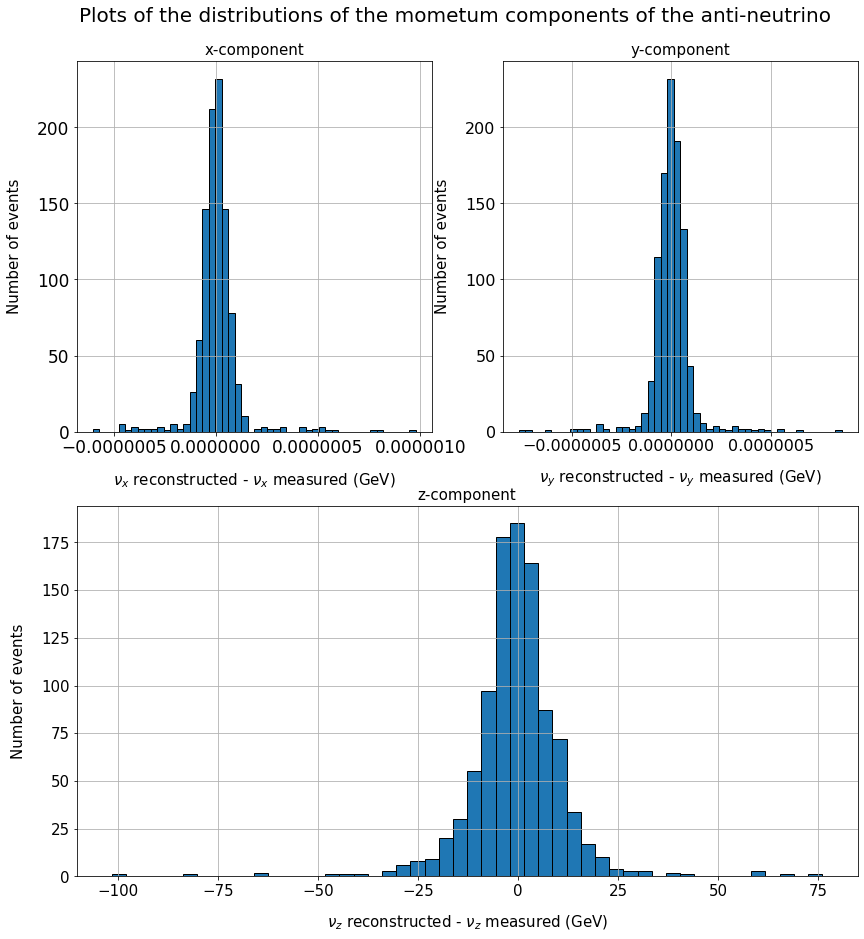

In [61]:
## Difference between measured & reconstructed for anti-neutrino ##
diffz = pzrecon-pzmsure
diffx = pxrecon-pxmsure
diffy = pyrecon-pymsure

fig = plt.figure(figsize=[14,15])
fig.suptitle(r"Plots of the distributions of the mometum components of the anti-neutrino", size= 20, y=0.93)

ax1=fig.add_subplot(221)
ax1.hist(diffx,bins=50, ec='black')
ax1.grid(True)
ax1.tick_params(axis ='both', labelsize=17)
ax1.set_xlabel(r"$\nu_x$ reconstructed - $\nu_x $ measured (GeV)",labelpad = 15, size= 15)
ax1.set_ylabel("Number of events",labelpad = 15, size= 15)
ax1.set_title("x-component", size = 15)
rmsx = np.sqrt(np.mean(diffx**2)) # rms of the distribution
print("The rmsX of the distribution is ", rmsx)

ax2=fig.add_subplot(222)
ax2.hist(diffy,bins=50,ec='black')
ax2.grid(True)
ax2.tick_params(axis ='both', labelsize=16)
ax2.set_xlabel(r"$\nu_y$ reconstructed - $\nu_y $ measured (GeV)",labelpad = 15, size= 15)
ax2.set_ylabel("Number of events",labelpad = 15, size= 15)
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.set_title("y-component", size = 15)
rmsy = np.sqrt(np.mean(diffy**2)) # rms of the distribution
print("The rmsY of the distribution is ", rmsy)

ax3= fig.add_subplot(212)
ax3.hist(diffz,bins = 50, ec="black")
ax3.grid(True)
ax3.tick_params(axis ='both', labelsize=15)
ax3.set_xlabel(r"$\nu_z$ reconstructed - $\nu_z$ measured (GeV)",labelpad = 15, size= 15)
ax3.set_ylabel("Number of events",labelpad = 15, size= 15)
ax3.set_title("z-component", size = 15)
rmsz = np.sqrt(np.mean(diffz**2)) # rms of the distribution
print("The rmsZ of the distribution is ", rmsz)

#plt.savefig("neutrino components smeared.png")

#### Final plots for W1 

The rmsX of the distribution is  1.2084923049179073e-07
The rmsY of the distribution is  1.2130886398373403e-07
The rmsZ of the distribution is  11.746733352867224


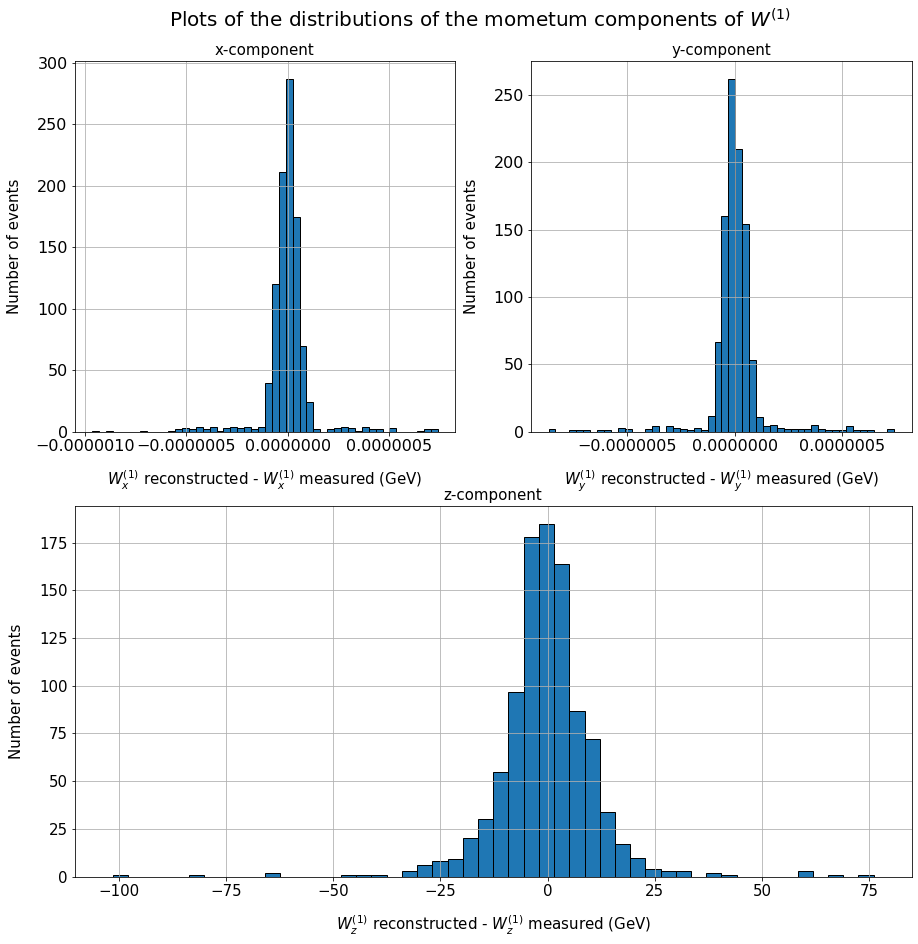

In [62]:
## Difference between measured & reconstructed for neutrino ##
diffw1z = W1pzrecon-W1pzmsure
diffw1x = W1pxrecon-W1pxmsure
diffw1y = W1pyrecon-W1pymsure

fig = plt.figure(figsize=[15,15])
fig.suptitle(r"Plots of the distributions of the mometum components of $W^{\left(1\right)}$", size= 20, y=0.93)

ax1=fig.add_subplot(221)
ax1.hist(diffw1x,bins=50, ec='black')
ax1.grid(True)
ax1.tick_params(axis ='both', labelsize=16)
ax1.set_xlabel(r"$W^{\left(1\right)}_x$ reconstructed - $W^{\left(1\right)}_x $ measured (GeV)",labelpad = 15, size= 15)
ax1.set_ylabel("Number of events",labelpad = 15, size= 15)
ax1.set_title("x-component", size = 15)
rmsx = np.sqrt(np.mean(diffw1x**2)) # rms of the distribution
print("The rmsX of the distribution is ", rmsx)

ax2=fig.add_subplot(222)
ax2.hist(diffw1y,bins=50,ec='black')
ax2.grid(True)
ax2.tick_params(axis ='both', labelsize=16)
ax2.set_xlabel(r"$W^{\left(1\right)}_y$ reconstructed - $W^{\left(1\right)}_y $ measured (GeV)",labelpad = 15, size= 15)
ax2.set_ylabel("Number of events",labelpad = 15, size= 15)
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.set_title("y-component", size = 15)
rmsy = np.sqrt(np.mean(diffw1y**2)) # rms of the distribution
print("The rmsY of the distribution is ", rmsy)

ax3= fig.add_subplot(212)
ax3.hist(diffw1z,bins = 50, ec="black")
ax3.grid(True)
ax3.tick_params(axis ='both', labelsize=15)
ax3.set_xlabel(r"$W^{\left(1\right)}_z$ reconstructed - $W^{\left(1\right)}_z$ measured (GeV)",labelpad = 15, size= 15)
ax3.set_ylabel("Number of events",labelpad = 15, size= 15)
ax3.set_title("z-component", size = 15)
rmsz = np.sqrt(np.mean(diffw1z**2)) # rms of the distribution
print("The rmsZ of the distribution is ", rmsz)

#plt.savefig("w1 components smearing.png")

#### Final plots for W2 

The rmsX of the distribution is  1.1251841171815082
The rmsY of the distribution is  1.1445360327109404
The rmsZ of the distribution is  10.108573051869419


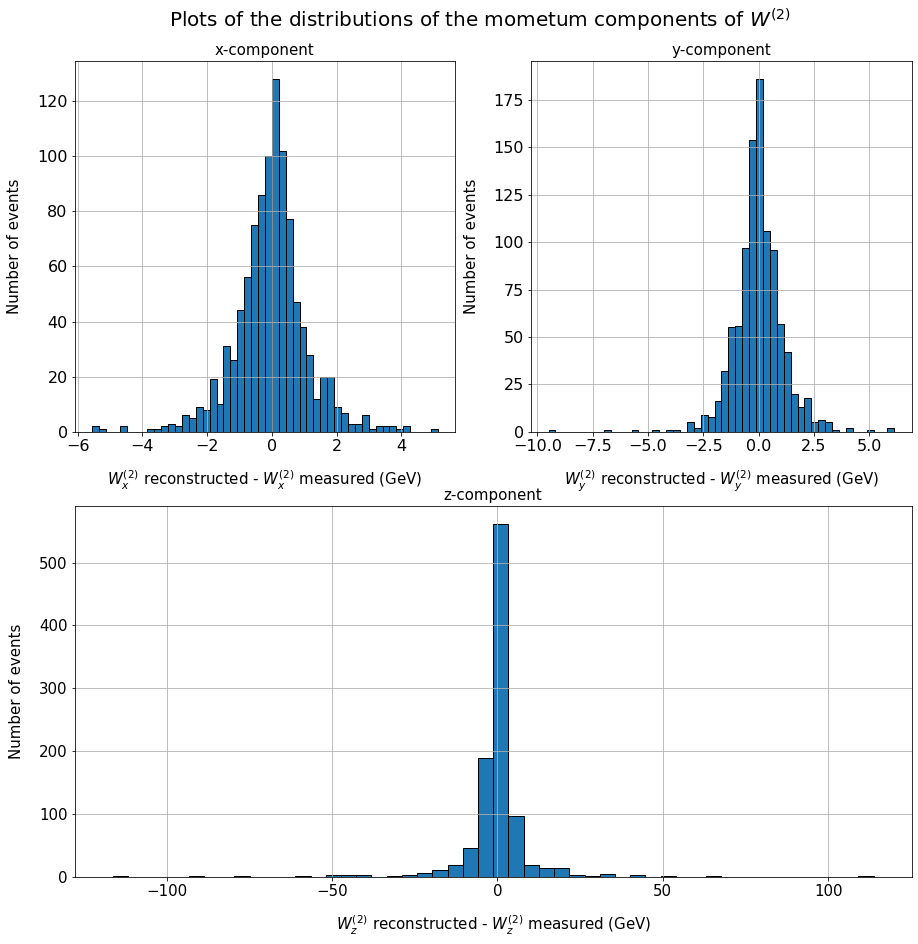

In [63]:
diffw2z = W2pzrecon-W2pzmsure
diffw2x = W2pxrecon-W2pxmsure
diffw2y = W2pyrecon-W2pymsure

fig = plt.figure(figsize=[15,15])
fig.suptitle(r"Plots of the distributions of the mometum components of $W^{\left(2\right)}$", size= 20, y=0.93)

ax1=fig.add_subplot(221)
ax1.hist(diffw2x,bins=50, ec='black')
ax1.grid(True)
ax1.tick_params(axis ='both', labelsize=16)
ax1.set_xlabel(r"$W^{\left(2\right)}_x$ reconstructed - $W^{\left(2\right)}_x $ measured (GeV)",labelpad = 15, size= 15)
ax1.set_ylabel("Number of events",labelpad = 15, size= 15)
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.set_title("x-component", size = 15)
rmsx = np.sqrt(np.mean(diffw2x**2)) # rms of the distribution
print("The rmsX of the distribution is ", rmsx)

ax2=fig.add_subplot(222)
ax2.hist(diffw2y,bins=50,ec='black')
ax2.grid(True)
ax2.tick_params(axis ='both', labelsize=16)
ax2.set_xlabel(r"$W^{\left(2\right)}_y$ reconstructed - $W^{\left(2\right)}_y $ measured (GeV)",labelpad = 15, size= 15)
ax2.set_ylabel("Number of events",labelpad = 15, size= 15)
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.set_title("y-component", size = 15)
rmsy = np.sqrt(np.mean(diffw2y**2)) # rms of the distribution
print("The rmsY of the distribution is ", rmsy)

ax3= fig.add_subplot(212)
ax3.hist(diffw2z,bins = 50, ec="black")
ax3.grid(True)
ax3.tick_params(axis ='both', labelsize=15)
ax3.set_xlabel(r"$W^{\left(2\right)}_z$ reconstructed - $W^{\left(2\right)}_z$ measured (GeV)",labelpad = 15, size= 15)
ax3.set_ylabel("Number of events",labelpad = 15, size= 15)
ax3.ticklabel_format(useOffset=False, style='plain')
ax3.set_title("z-component", size = 15)
rmsz = np.sqrt(np.mean(diffw2z**2)) # rms of the distribution
print("The rmsZ of the distribution is ", rmsz)

#plt.savefig("w2 components smeared.png")

## 4) Distribution of the angle between truth and reconstructed Ws

Now we will find the angles $\theta$:
$$\theta =\arccos \left(\frac{\begin{pmatrix}P_x\\ P_y\\ P_z\end{pmatrix}\cdot \begin{pmatrix}P_x'\\ P_y'\\ P_z'\end{pmatrix}}{\left|P\right|\left|P'\right|}\right)  \tag 1 $$
where $\theta_1$ and $\theta_2$ are the angles between motions of reconstructed W and truth W for 1000 events for each W boson. First W corresponds to MCN 24 and second W correponds to MCN -24. $\mathbf{P}$ is the reconstructed and $\mathbf{P}^\prime$ is the truth from the data set. 





### 4.1) Using reconstructed data with proton and jets smearing

We will be finding the angles using the reconstruction from section (3) which had smearing for the protons and jets. Then we will plot a histogram for the distribution of this angle.

In [64]:
## Calculating angles between reconstruction and truth for each W boson ##

theta1ARRAY = np.empty((0,3), int) #first W
theta2ARRAY = np.empty((0,3), int) #second W

# Note we use the varibles from section 3 for the reconstructed data 
for i in range(1,1001):
    # Dot product of reconstructed with truth for W1
    dotprod1 = W1pxrecon[i-1]*globals()[f'event{i}'].Px[3]+W1pyrecon[i-1]*globals()[f'event{i}'].Py[3]+W1pzrecon[i-1]*globals()[f'event{i}'].Pz[3]
    # Product of the moduli of the truth and reconstructed momenta vectors of W1
    abs1 = np.sqrt(W1pxrecon[i-1]**2+W1pyrecon[i-1]**2+W1pzrecon[i-1]**2)*np.sqrt(globals()[f'event{i}'].Px[3]**2+globals()[f'event{i}'].Py[3]**2+globals()[f'event{i}'].Pz[3]**2)
    theta1 = np.arccos(dotprod1/abs1) #angle for first W boson in degrees
    
    # Dot product of reconstructed with truth for W2
    dotprod2 = W2pxrecon[i-1]*globals()[f'event{i}'].Px[4]+W2pyrecon[i-1]*globals()[f'event{i}'].Py[4]+W2pzrecon[i-1]*globals()[f'event{i}'].Pz[4]
    # Product of the moduli of the truth and reconstructed momenta vectors of W2
    abs2 = np.sqrt(W2pxrecon[i-1]**2+W2pyrecon[i-1]**2+W2pzrecon[i-1]**2)*np.sqrt(globals()[f'event{i}'].Px[4]**2+globals()[f'event{i}'].Py[4]**2+globals()[f'event{i}'].Pz[4]**2)
    theta2 = np.arccos(dotprod2/abs2) #angle for second W boson in degrees
    #print("theta_1 is",theta1, "theta_2 is", theta2,"for event",i)
    
    theta1ARRAY = np.append(theta1ARRAY,theta1) 
    theta2ARRAY = np.append(theta2ARRAY,theta2) 

#### Histogram plots using pyplot
We will create a matplot library for the distribution of $\theta_1$ and $\theta_2$.

The rms1 of the distribution is  0.07319922873151219
The rms of the distribution is  0.014222785937870526


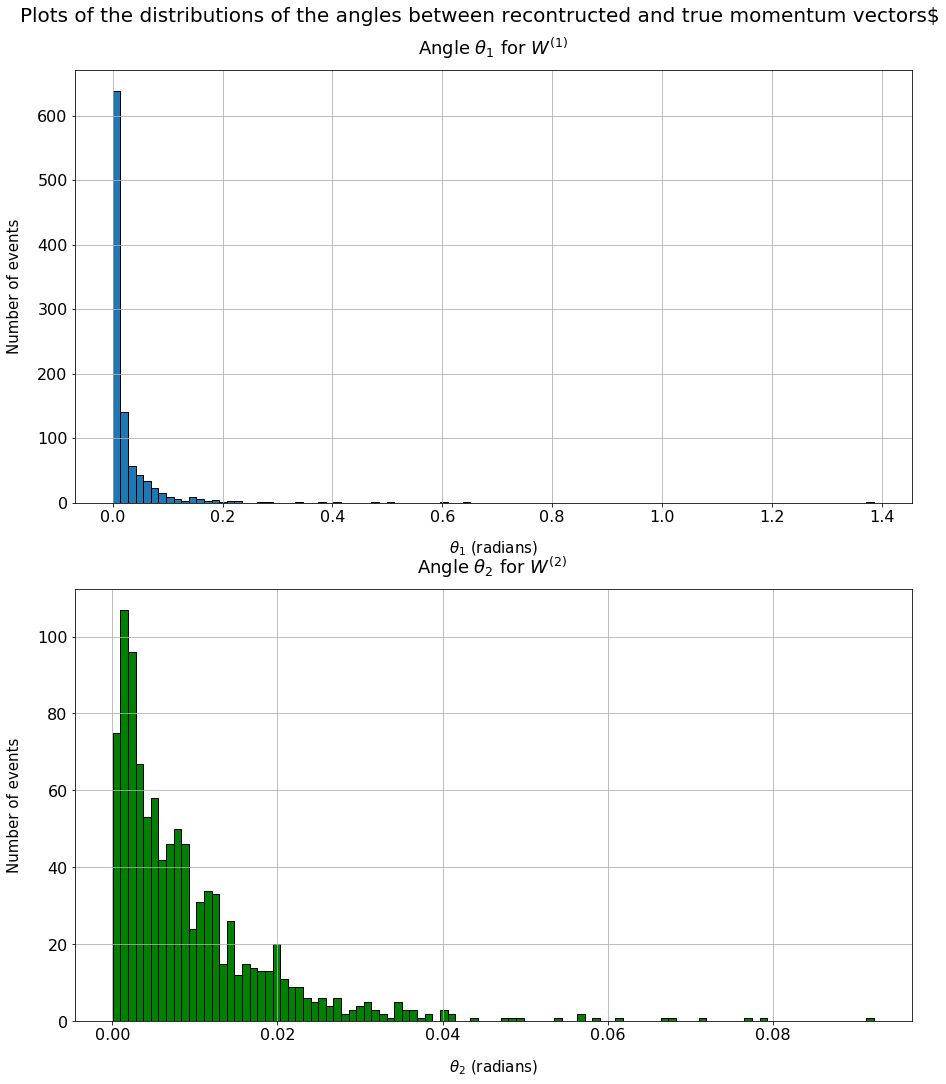

In [65]:
## Angle distributions##
fig = plt.figure(figsize=[15,17.5])
fig.suptitle(r"Plots of the distributions of the angles between recontructed and true momentum vectors$", size= 20, y=.93)
ax1 = fig.add_subplot(211)
ax1.hist(theta1ARRAY,bins = 100,  ec='black')
ax1.grid(True)
ax1.tick_params(axis ='both', labelsize=16)
ax1.set_ylabel(r"Number of events",labelpad = 15, size= 15)
ax1.set_xlabel(r"$\theta_1$ (radians)",labelpad = 15, size= 15)
ax1.set_title(r"Angle $\theta_1$ for $W^{\left(1\right)}$",pad = 15, size= 18)
ax1.ticklabel_format(useOffset=False, style='plain')
rms1 = np.sqrt(np.mean(theta1ARRAY**2)) # rms of the distribution
print("The rms1 of the distribution is ", rms1)


ax2 = fig.add_subplot(212)
ax2.hist(theta2ARRAY,bins = 100,color = "g",  ec='black')
ax2.grid(True)
ax2.tick_params(axis ='both', labelsize=16)
ax2.set_ylabel(r"Number of events",labelpad = 15, size= 15)
ax2.set_xlabel(r"$\theta_2$ (radians)",labelpad = 15, size= 15)
ax2.set_title(r"Angle $\theta_2$ for $W^{\left(2\right)}$ ",pad = 15, size= 18)
ax2.ticklabel_format(useOffset=False, style='plain')
rms2 = np.sqrt(np.mean(theta2ARRAY**2)) # rms of the distribution
print("The rms of the distribution is ", rms2)
#plt.savefig("angles with smearing.png")

We note how for W1 there are a bunch of events for which the angle is significant. But more than half of the events have an angle $\theta_1 \lt 1$ suggesting that the reconstruction with proton smearing doesn't have much of an effect for the most part.

For W2 we note that the range of the angles is much smaller than W1 suggesting that the jet smearing doesnt introduce as much of an error. Most of the evets have an angle $\theta_2 \lt 1$ here too with a few outliers.

### 4.2) Using reconstructed data without smearing

We will be finding the angles using the reconstruction from section (1) which had no smearing. Then we will plot a histogram for the distribution of this angle.

In [66]:
## redoing section 1 ##

## Pz
pzrecon = np.empty((0,3), int) #reconstructed
pzmsure = np.empty((0,3), int) #measured
W1pzrecon = np.empty((0,3), int) #w1 reconstructed
W2pzrecon = np.empty((0,3), int) #w2 reconstructed
W1pzmsure = np.empty((0,3), int) #w1 measured
W2pzmsure = np.empty((0,3), int) #w2 measured

for y in range(1,1001):
    
    WWsystem = -1*(globals()[f'event{y}'].Pz[0]+globals()[f'event{y}'].Pz[1])  # WW system Pz = - total Pz of both protons
    ## now we minus the Pz value we know from the total WW system i.e. the muon and jets 
    neutrinoPz = WWsystem - globals()[f'event{y}'].Pz[6] - globals()[f'event{y}'].Pz[7] - globals()[f'event{y}'].Pz[8]
    w1 = neutrinoPz + globals()[f'event{y}'].Pz[6]
    w2 = globals()[f'event{y}'].Pz[7] + globals()[f'event{y}'].Pz[8]
    #print("v_mu Pz=",neutrinoPz,"W1 Pz=",w1,"W2 Pz=",w2,"for event",y)
    
    pzrecon = np.append(pzrecon,neutrinoPz) # filling array with the reconstructed Pz for neutrino
    pzmsure = np.append(pzmsure,globals()[f'event{y}'].Pz[5]) # filling array with the measured Pz for neutrino
    W1pzrecon = np.append(W1pzrecon,w1)
    W2pzrecon = np.append(W2pzrecon,w2)
    W1pzmsure = np.append(W1pzmsure,globals()[f'event{y}'].Pz[3])
    W2pzmsure = np.append(W2pzmsure,globals()[f'event{y}'].Pz[4])


## Px
pxrecon = np.empty((0,3), int) #reconstructed
pxmsure = np.empty((0,3), int) #measured
W1pxrecon = np.empty((0,3), int) #w1 reconstructed
W2pxrecon = np.empty((0,3), int) #w2 reconstructed
W1pxmsure = np.empty((0,3), int) #w1 measured
W2pxmsure = np.empty((0,3), int) #w2 measured

for y in range(1,1001):
    
    WWsystem = -1*(globals()[f'event{y}'].Px[0]+globals()[f'event{y}'].Px[1])  # WW system Px = - total Px of both protons
    ## now we minus the Px value we know from the total WW system i.e. the muon and jets 
    neutrinoPx = WWsystem - globals()[f'event{y}'].Px[6] - globals()[f'event{y}'].Px[7] - globals()[f'event{y}'].Px[8]
    w1 = neutrinoPx + globals()[f'event{y}'].Px[6]
    w2 = globals()[f'event{y}'].Px[7] + globals()[f'event{y}'].Px[8]
    #print("v_mu Px=",neutrinoPx,"W1 Px=",w1,"W2 Px=",w2,"for event",y)
    
    pxrecon = np.append(pxrecon,neutrinoPx) # filling array with the reconstructed Px for neutrino
    pxmsure = np.append(pxmsure,globals()[f'event{y}'].Px[5]) # filling array with the measured Px for neutrino
    W1pxrecon = np.append(W1pxrecon,w1)
    W2pxrecon = np.append(W2pxrecon,w2)
    W1pxmsure = np.append(W1pxmsure,globals()[f'event{y}'].Px[3])
    W2pxmsure = np.append(W2pxmsure,globals()[f'event{y}'].Px[4])

## Py
pyrecon = np.empty((0,3), int) #reconstructed
pymsure = np.empty((0,3), int) #measured
W1pyrecon = np.empty((0,3), int) #w1 reconstructed
W2pyrecon = np.empty((0,3), int) #w2 reconstructed
W1pymsure = np.empty((0,3), int) #w1 measured
W2pymsure = np.empty((0,3), int) #w2 measured

for y in range(1,1001):
    
    WWsystem = -1*(globals()[f'event{y}'].Py[0]+globals()[f'event{y}'].Py[1])  # WW system Py = - total Py of both protons
    ## now we minus the Py value we know from the total WW system i.e. the muon and jets 
    neutrinoPy = WWsystem - globals()[f'event{y}'].Py[6] - globals()[f'event{y}'].Py[7] - globals()[f'event{y}'].Py[8]
    w1 = neutrinoPy + globals()[f'event{y}'].Py[6]
    w2 = globals()[f'event{y}'].Py[7] + globals()[f'event{y}'].Py[8]
    #print("v_mu Py=",neutrinoPy,"W1 Py=",w1,"W2 Py",w2,"for event",y)
    
    pyrecon = np.append(pyrecon,neutrinoPy) # filling array with the reconstructed Py for neutrino
    pymsure = np.append(pymsure,globals()[f'event{y}'].Py[5]) # filling array with the measured Px for neutrino
    W1pyrecon = np.append(W1pyrecon,w1)
    W2pyrecon = np.append(W2pyrecon,w2)
    W1pymsure = np.append(W1pymsure,globals()[f'event{y}'].Py[3])
    W2pymsure = np.append(W2pymsure,globals()[f'event{y}'].Py[4])

In [67]:
## Calculating angles between reconstruction and truth for each W boson for no smearing case ##

theta1ARRAY = np.empty((0,3), int) #first W
theta2ARRAY = np.empty((0,3), int) #second W

# Note we use the varibles from section 3 for the reconstructed data 
for i in range(1,1001):
    # Dot product of reconstructed with truth for W1
    dotprod1 = W1pxrecon[i-1]*globals()[f'event{i}'].Px[3]+W1pyrecon[i-1]*globals()[f'event{i}'].Py[3]+W1pzrecon[i-1]*globals()[f'event{i}'].Pz[3]
    # Product of the moduli of the truth and reconstructed momenta vectors of W1
    abs1 = np.sqrt(W1pxrecon[i-1]**2+W1pyrecon[i-1]**2+W1pzrecon[i-1]**2)*np.sqrt(globals()[f'event{i}'].Px[3]**2+globals()[f'event{i}'].Py[3]**2+globals()[f'event{i}'].Pz[3]**2)
    inside = dotprod1/abs1
    if inside - 1>0:
        inside =1
    theta1 = np.arccos(inside) #angle for first W boson in radians
    
    # Dot product of reconstructed with truth for W2
    dotprod2 = W2pxrecon[i-1]*globals()[f'event{i}'].Px[4]+W2pyrecon[i-1]*globals()[f'event{i}'].Py[4]+W2pzrecon[i-1]*globals()[f'event{i}'].Pz[4]
    # Product of the moduli of the truth and reconstructed momenta vectors of W2
    abs2 = np.sqrt(W2pxrecon[i-1]**2+W2pyrecon[i-1]**2+W2pzrecon[i-1]**2)*np.sqrt(globals()[f'event{i}'].Px[4]**2+globals()[f'event{i}'].Py[4]**2+globals()[f'event{i}'].Pz[4]**2)
    inside = dotprod2/abs2
    if inside - 1 >0: # to avoid precision errors of inside = 1.000000002 for example
        inside =1
    theta2 = np.arccos(inside)  #angle for second W boson
    #print("theta_1 is",theta1, "theta_2 is", theta2,"for event",i)
    
    theta1ARRAY = np.append(theta1ARRAY,theta1) 
    theta2ARRAY = np.append(theta2ARRAY,theta2) 

#### Histogram plots

The rms1 of the distribution is  3.3259979280458185e-08
The rms of the distribution is  8.283222979120789e-09


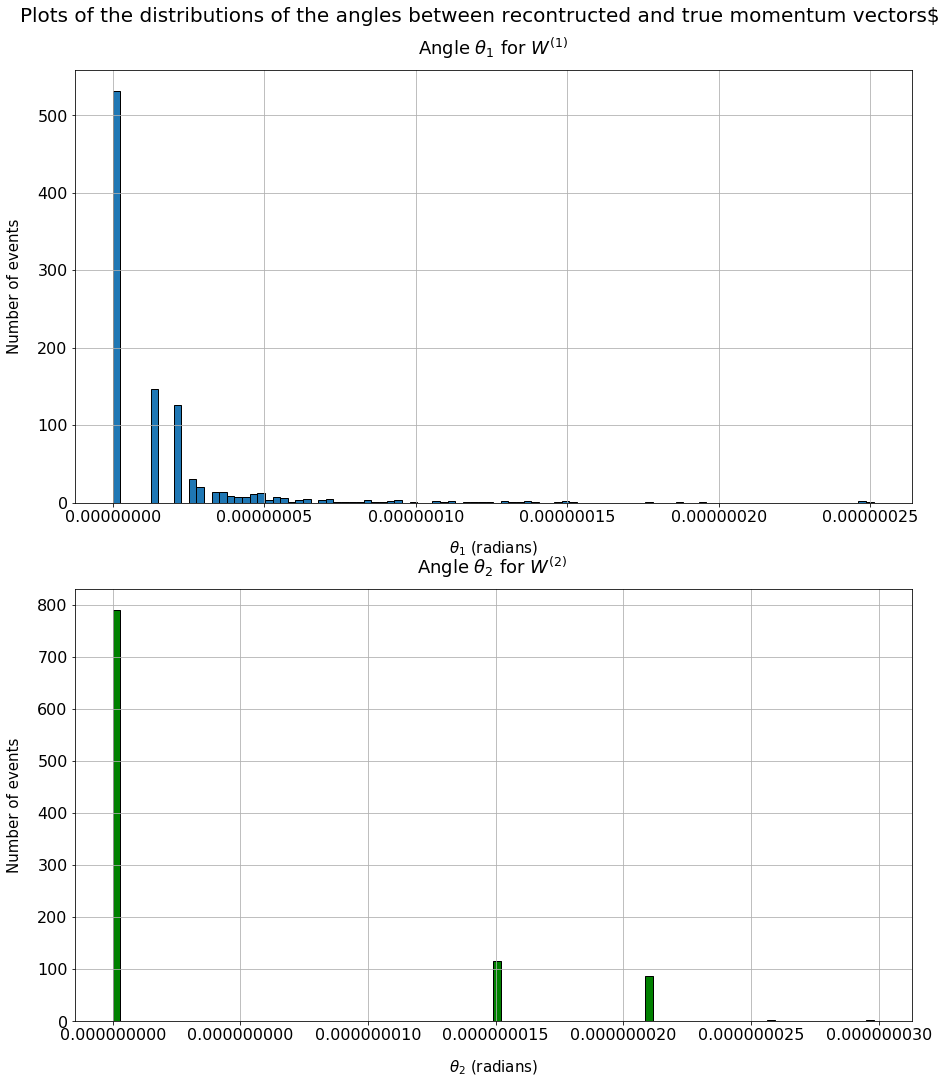

In [68]:
## Angle distributions##
fig = plt.figure(figsize=[15,17.5])
fig.suptitle(r"Plots of the distributions of the angles between recontructed and true momentum vectors$", size= 20, y=.93)
ax1 = fig.add_subplot(211)
ax1.hist(theta1ARRAY,bins = 100,  ec='black')
ax1.grid(True)
ax1.tick_params(axis ='both', labelsize=16)
ax1.set_ylabel(r"Number of events",labelpad = 15, size= 15)
ax1.set_xlabel(r"$\theta_1$ (radians)",labelpad = 15, size= 15)
ax1.set_title(r"Angle $\theta_1$ for $W^{\left(1\right)}$",pad = 15, size= 18)
ax1.ticklabel_format(useOffset=False, style='plain')
rms1 = np.sqrt(np.mean(theta1ARRAY**2)) # rms of the distribution
print("The rms1 of the distribution is ", rms1)


ax2 = fig.add_subplot(212)
ax2.hist(theta2ARRAY,bins = 100,color="g" , ec='black')
ax2.grid(True)
ax2.tick_params(axis ='both', labelsize=16)
ax2.set_ylabel(r"Number of events",labelpad = 15, size= 15)
ax2.set_xlabel(r"$\theta_2$ (radians)",labelpad = 15, size= 15)
ax2.set_title(r"Angle $\theta_2$ for $W^{\left(2\right)}$ ",pad = 15, size= 18)
ax2.ticklabel_format(useOffset=False, style='plain')
rms2 = np.sqrt(np.mean(theta2ARRAY**2)) # rms of the distribution
print("The rms of the distribution is ", rms2)
plt.savefig("angles no smearing.png")

We see there is practically no difference in the W-directions